__Пайплайн построения модели__
 
ЧАСТЬ А
 
1) Обучим стандартный CatBoost в качестве baseline
2) С помощью проверки гипотез попытаемся определить признаки, которые скорее всего несущественно влияют на целевую переменную
3) Будем по очереди перебирать эти признаки, обучать CatBoost без них и смотреть, как оно влияет на качество моделей. Уберём то, что не меняет либо почти не меняет ROC-AUC (это если вдруг такие признаки найдутся)
4) Отнормируем данные, посмотрим на качество после нормировки и до нормировки
5) Нагенерируем 100500 признаков - полиномы, синусы, экспоненты
6) Попробуем разные вариации генерации признаков исходя из компьютерных мощностей

ЧАСТЬ B

7) Используя квантизацию признаков сгенерируем новый признак, отвечающий за принадлежность к кластеру, проверим SMOTE
8) Подберём оптимальный порог t для нашей модели максимизирующий f-score



Подгрузим все необходимые библиотеки 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve
from scipy import stats
from scipy.stats import bartlett
from scipy.stats import levene
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [2]:
df = pd.read_csv('project_train.csv')
y_train = df['311']
df = df.drop('Unnamed: 0', axis = 1)
df = df.drop('311', axis = 1)


df.head()

,0,1,2,3,4,5,6,7,8,9,...,301,302,303,304,305,306,307,308,309,310
0,0.243564,0.302197,0.000259,0.000331,2379.867100,1583.673987,1988.863977,1177.816996,4596.225081,3070.398615,...,0.000002,0.000003,0.000002,0.000002,0.000001,0.000001,9.547306e-07,7.960268e-07,3.732888e-07,3.126712e-08
1,0.398592,0.290751,0.008298,0.006522,2549.703359,902.814666,2434.436152,621.608576,5227.102239,2044.925894,...,0.001280,0.001251,0.000947,0.000886,0.001016,0.000698,7.218310e-04,1.213449e-03,7.527992e-04,5.277236e-05
2,0.332872,0.306482,0.045383,0.020386,2496.088753,1065.052254,2415.676166,735.048307,5054.339694,2311.583265,...,0.055103,0.082897,0.042400,0.045215,0.046453,0.042490,4.016979e-02,4.328870e-02,2.639336e-02,2.995682e-03
3,0.374518,0.291596,0.106776,0.052839,2804.832168,1061.562911,2544.598453,567.635555,5698.016827,1970.422738,...,0.129767,0.182320,0.119765,0.088639,0.094064,0.069251,5.209206e-02,6.751129e-02,4.142033e-02,3.045732e-03
4,0.376507,0.290995,0.158438,0.060707,2622.996230,1036.870399,2500.696752,622.321587,5380.319261,2131.597207,...,0.306220,0.384795,0.200407,0.171049,0.307872,0.199622,1.875423e-01,2.183229e-01,1.948708e-01,1.540417e-02


### ANOVA

С ней возникли большие проблемы. В качестве предпосылки дисперсионный анализ требует нормальность остатков и незавсимость групп, для которых ANOVA проводится (а так же равенство внутригрупповых дисперсий aka гомоскедастичность). К сожалению, почти ни для каких признаков в нашей матрице эти условия не выполняются. Это мы и продемонстрируем чуть позже. А пока взгляните на распределение рандомного признака для разных классов. Не особо похоже на нормальное, правда? А что там с гомоскедастичностью, так я вообще молчу) взглянешь на эти боксплоты и захочется плакать

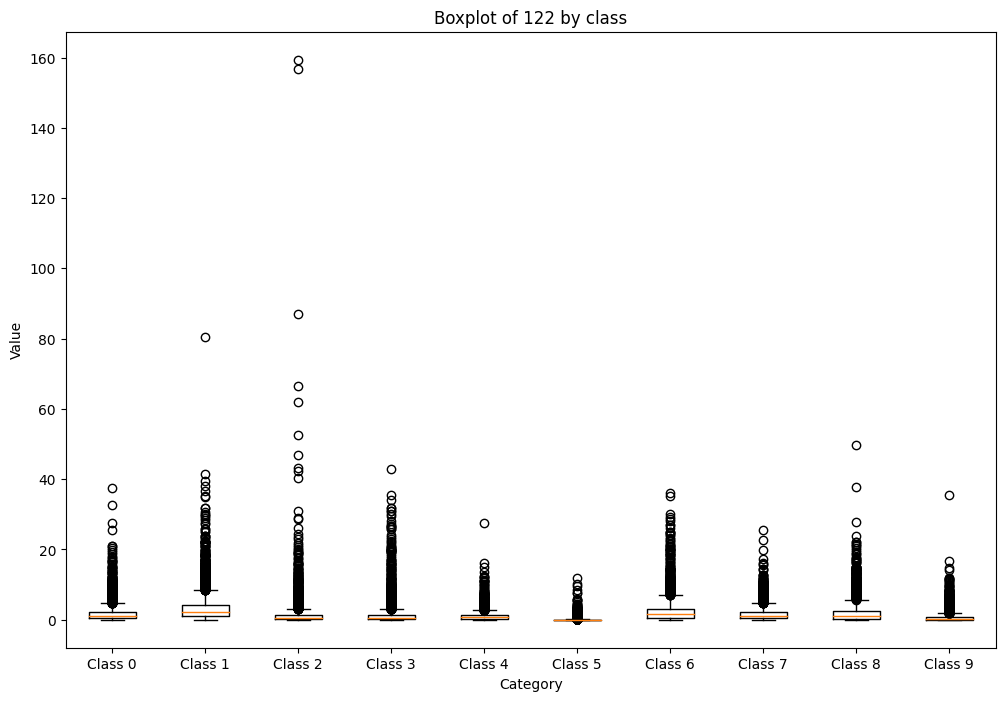

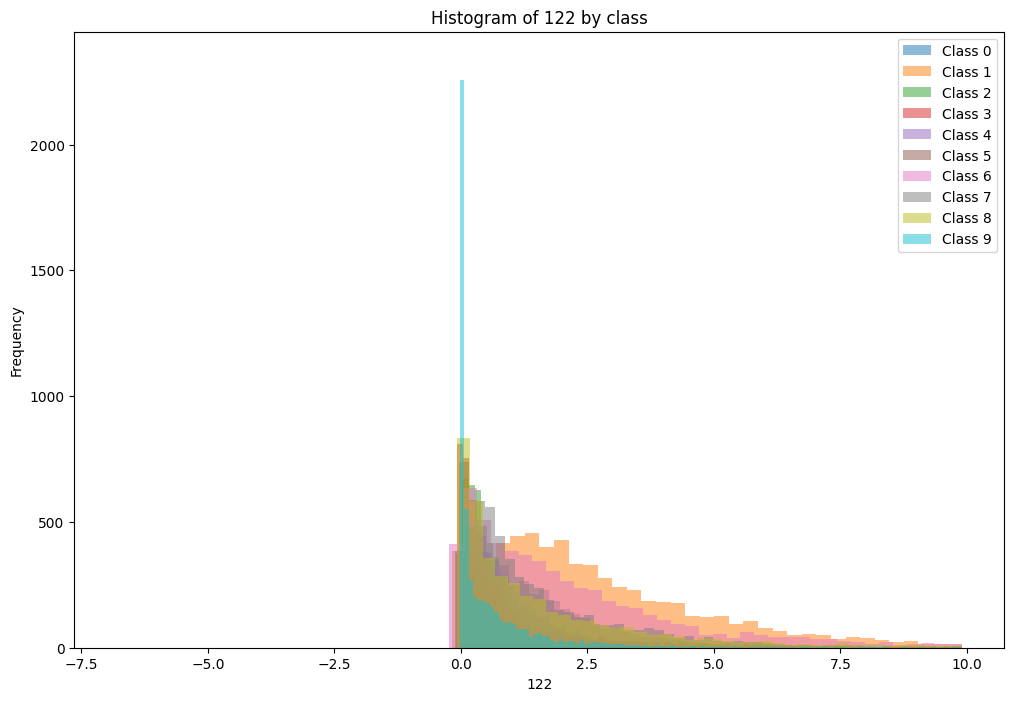

In [5]:
def show_feat_distr_by_class(df, column):
    grouped_data = pd.concat([df, y_train], axis = 1).groupby('311')[column].apply(list)

    plt.figure(figsize=(12, 8))
    boxplot_data = []
    labels = []
    for category, values in grouped_data.items():
        boxplot_data.append(values)
        labels.append(f'Class {int(category)}')
    
    plt.boxplot(boxplot_data, labels=labels)
    plt.title(f'Boxplot of {column} by class')
    plt.xlabel('Category')
    plt.ylabel('Value')
    plt.show()

    plt.figure(figsize=(12, 8))
    for category, values in grouped_data.items():
        plt.hist(values, bins='auto', density=False, alpha=0.5, label=f'Class {int(category)}', range=(df[column].mean() - 3 * df[column].std(), df[column].mean() + 3 * df[column].std()))
    
    plt.title(f'Histogram of {column} by class')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

show_feat_distr_by_class(df, '122')

Напишем функцию, с помощью которой найдём все признаки, остатки каждой группы для которых успешно проходят тест Шапиро-Уилка на нормальность с уровнем значимости 5%

In [7]:
def are_groups_in_feat_normal(df, column_name):
    grouped_data = pd.concat([df, y_train], axis = 1).groupby('311')[column_name].apply(list).to_dict()
    for key in grouped_data:
        _, p_value = stats.shapiro(grouped_data[key] - np.mean(grouped_data[key]))        
        if p_value < 0.05:
            return False
    return True    

res = []
for column in df:
    if column == '311':
        continue
    boolish = are_groups_in_feat_normal(df, column)
    if boolish:
        res.append(column)
print(res)

[]


Как мы видим, всё очень грустно.
А может, проверим предпосылку о том, дисперсии внутри групп равны? Используем критерий Бартлетта. Основная гипотеза состоит в том, что дисперсии всех групп равны.

In [9]:
def are_std_equal(df, column_name, test):
    grouped_data = pd.concat([df, y_train], axis = 1).groupby('311')[column_name].apply(list)
    statistics, p_value = test(*grouped_data.values)
    return p_value
  
equaled_std_bartlett = []
for column in df:
    if column == '311':
        continue
    p = are_std_equal(df, column, bartlett)
    if p > 0.05:
        equaled_std_bartlett.append(column)
print(equaled_std_bartlett)

[]


М-де, всё плоховато. Но вдруг такой результат связан с тем, что бартлетт слишком требователен к нормальности распределений? Давайте попробуем тест Левэна

In [11]:
equaled_std_leven = []
for column in pd.concat([df, y_train], axis = 1):
    if column == '311':
        continue
    p = are_std_equal(df, column, levene)
    if p > 0.05:
        equaled_std_leven.append(column)
print(equaled_std_leven)

[]


Для всех признаков гипотеза о том, что внутригрупповая дисперсия среди групп не отличается, отверглась. 
Как мы видим, для дисперсионного анализа не выполняеется ни предпосылка о нормальности распределений остатков, ни предпосылка
о равенстве внутригрупповых дисперий. Давайте ради приличия посмотрим, что выдаст нам анова в этих условиях. Естественно, ни о каком доверии к анове пока речи и не идёт

In [13]:
from scipy.stats import f_oneway

def perform_anova_test(df, column_name):
    grouped_data = pd.concat([df, y_train], axis = 1).groupby('311')[column_name].apply(list)
    statistics, p_value = f_oneway(*grouped_data.values)
    return statistics, p_value

for column in df:
    if column == '311':
        continue
    statistics_min = 10**4
    statistics, p = perform_anova_test(df, column)
    statistics_min = min(statistics, statistics_min)
    if p > 0.05:
        print(column)
print(statistics_min)        


705.9119515384344


Гипотеза о том, что в разбитом на группы по классам признаке эти самые группы все одинаковы, отвергается для каждого признака - т.е. наша ANOVA говорит что все признаки существенно влияют на целевую переменную. Предположение интересное, и возможно даже верное, но в условиях нарушения основных предпосылок крайне сомнительное. Вы просто взгляните на минимальное значение статистики - критическое крутится в районе 10)))

Чтож, нужно что-то придумывать. Давайте попробуем нормализовать наши данные с помощью метода Бокса-Кокса. Чтобы применить преобразование Бокса-Кокса, нужно, чтобы все значения признака были строго положительными. Давайте взглянем для скольких признаков эта предпосылка выполняется

In [14]:
number_of_appropriate_columns = 0
for column in pd.concat([df, y_train], axis = 1):
    if column == '311':
        continue
    if df[column].min() > 0:
        number_of_appropriate_columns += 1
print(number_of_appropriate_columns)
    

1


Только для одного признака из 311. Чтож, будем пробовать вставлять костыли. Давайте для удобства возьмём какой-нибудь случайный признак, и будем пробовать наши эксперименты на нём (для того чтобы у нас была возможность визуализировать результаты). Пусть это будет признак 8, почему нет?
Для начала познакомимся с основными характеристиками распределения признака через простую визуализацию


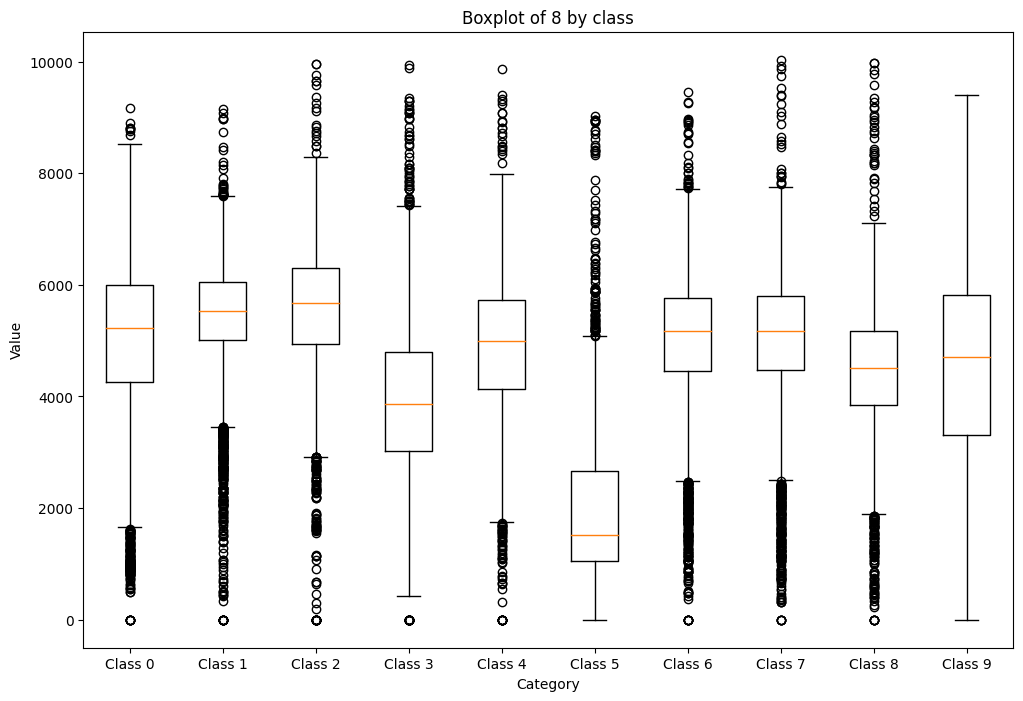

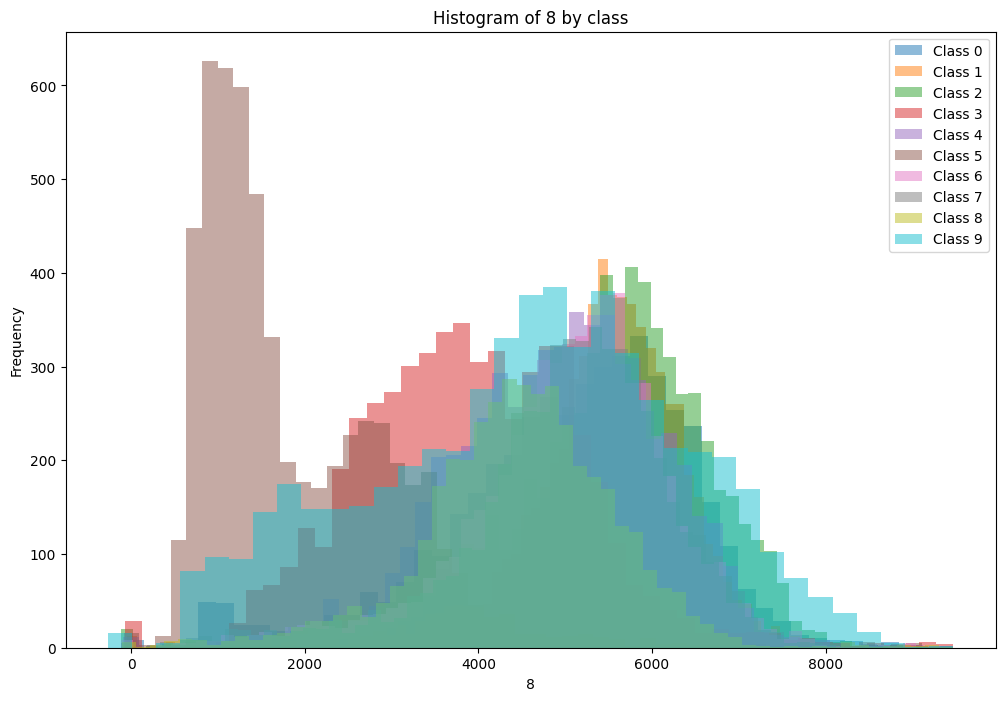

In [15]:
show_feat_distr_by_class(df, '8')

Посмотрим на то, для скольких и каких именно групп на данный момент нарушается предпосылка о нормальности распределения остатков

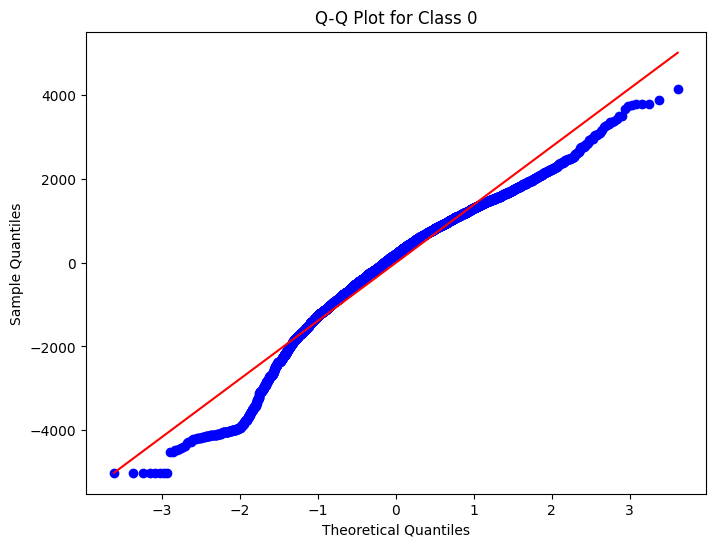

1.98626242153193e-34 class: 0


/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


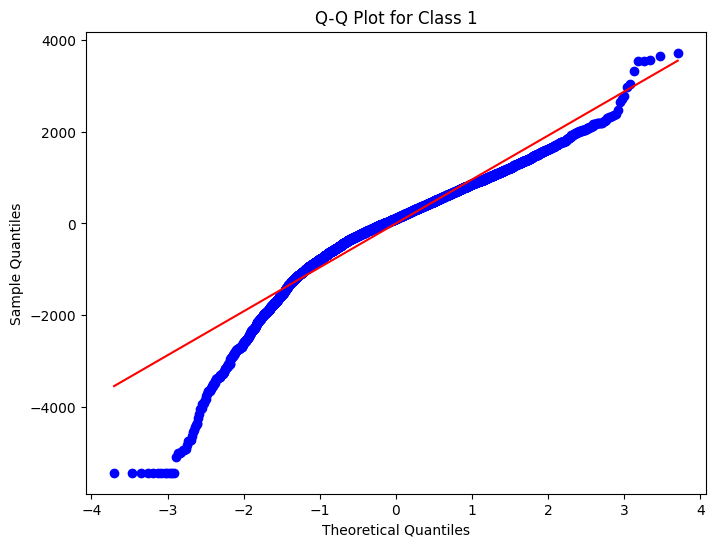

0.0 class: 1


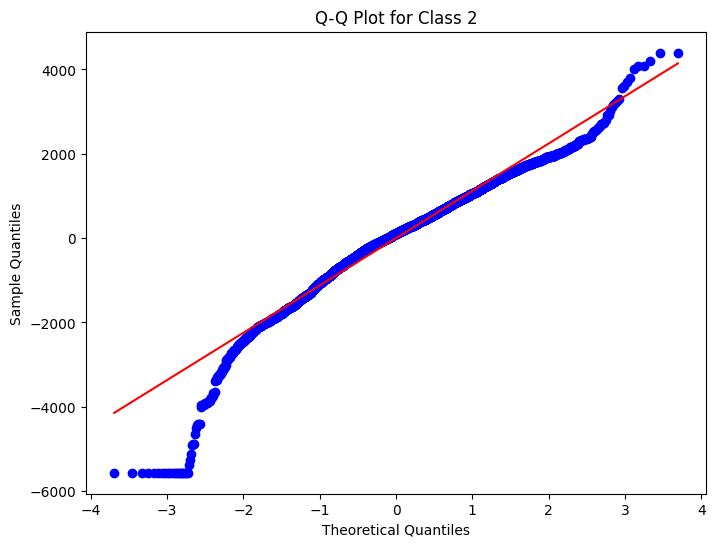

1.3258441247940075e-35 class: 2


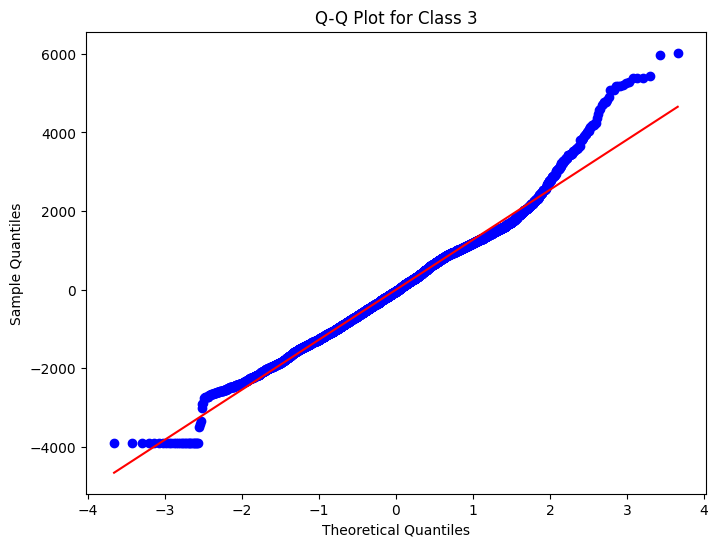

7.171034414659181e-22 class: 3


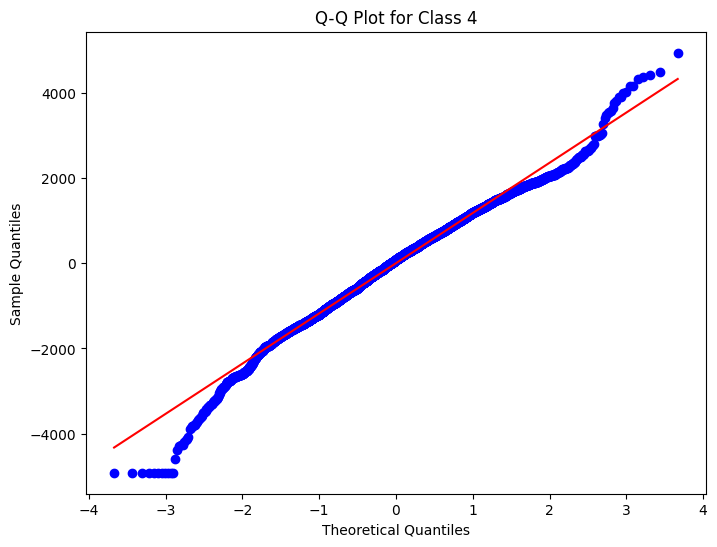

9.720161896489122e-20 class: 4


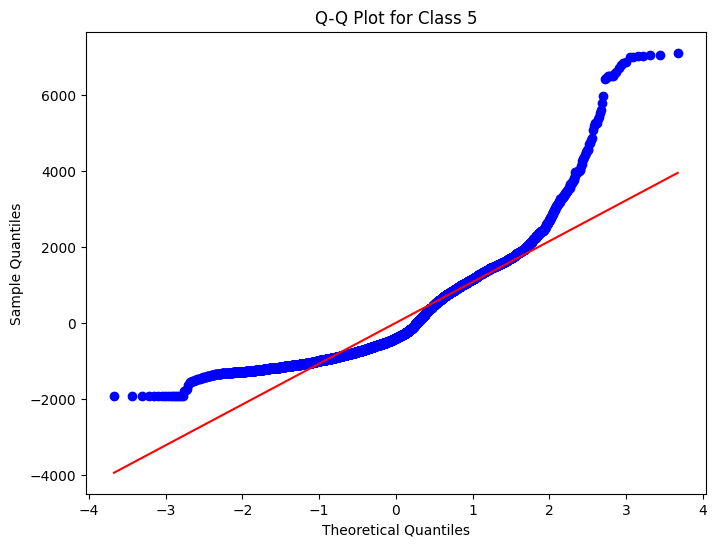

0.0 class: 5


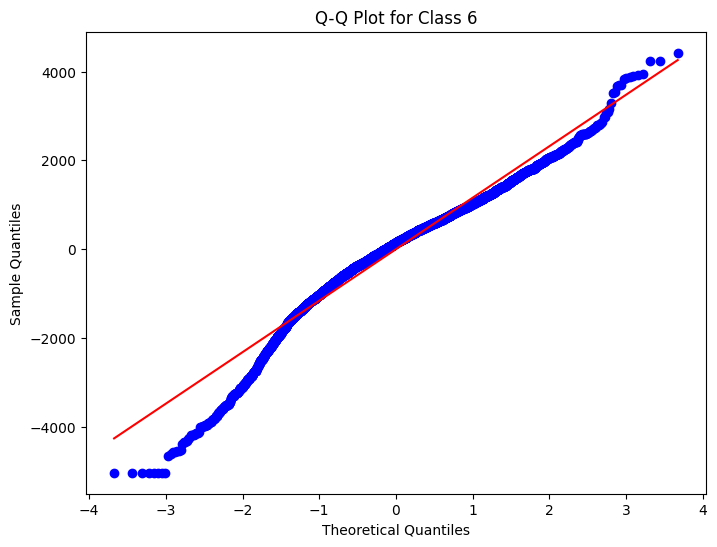

1.0636611372772834e-36 class: 6


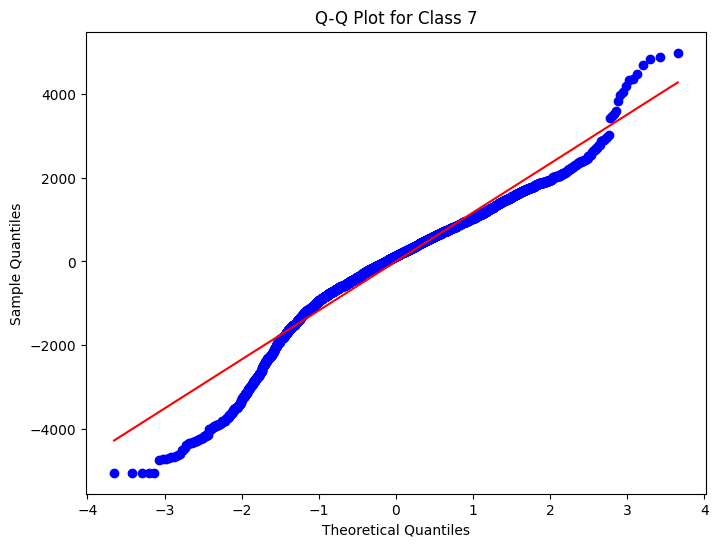

1.4870943641015683e-39 class: 7


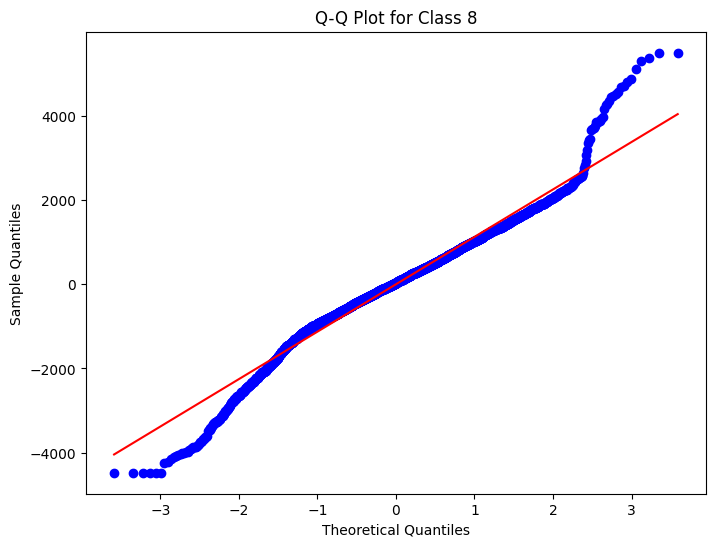

1.1680764149743613e-27 class: 8


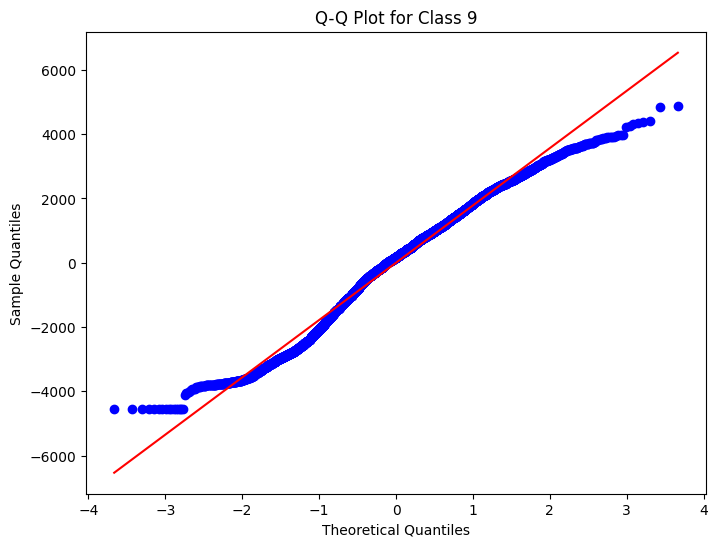

8.07352357042026e-24 class: 9


In [17]:
grouped_data_for_8 = pd.concat([df, y_train], axis = 1).groupby('311')["8"].apply(list).to_dict()
for key in grouped_data_for_8:
    _, p_value = stats.shapiro(grouped_data_for_8[key] - np.mean(grouped_data_for_8[key]))        
    plt.figure(figsize=(8, 6))
    stats.probplot(grouped_data_for_8[key] - np.mean(grouped_data_for_8[key]), dist='norm', plot=plt)
    plt.title(f'Q-Q Plot for Class {int(key)}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.show()
    print(p_value, 'class:', int(key))
  

Как мы видим по результатам тестов и по Q-Q графикам - нормальность остатков нарушается для всех классов. 

Давайте попробуем сам признак привести к нормальному используя преобразование Бокса-Кокса. Как я писал выше, чтобы его провести нужно, чтобы признак принимал только положительные значения, а это, как мы видим, нарушается для нашего распределения. Есть выход: прибавим модуль минимального значения признака ко всему ряду, это переведёт наши данные в положительные значения и позволит использовать преобразование Бокса-Кокса.

Q-Q плот до преобразований:

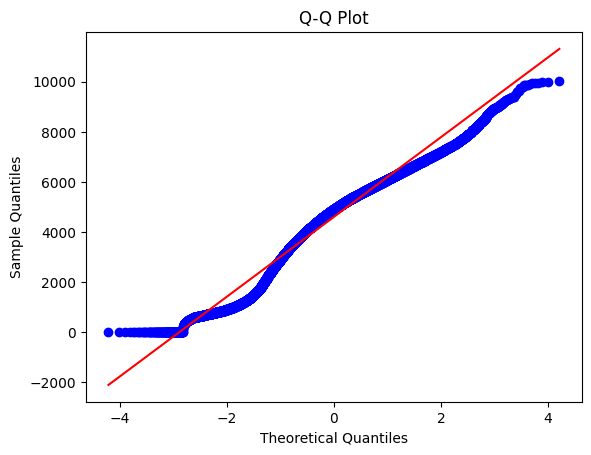

In [18]:
stats.probplot(df['8'], dist='norm', plot=plt)
plt.title('Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

После преобразований:

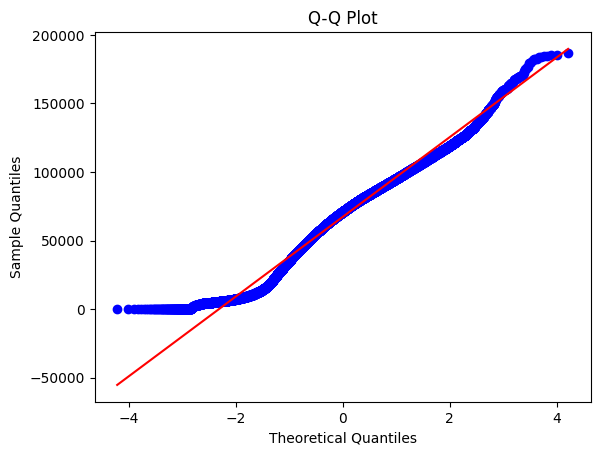

In [138]:
feat8 = df['8'] + abs(df['8'].min()) + 1
normilized_feat8, _ = stats.boxcox(feat8)
stats.probplot(normilized_feat8, dist='norm', plot=plt)
plt.title('Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

Как мы видим, даже после преобразованиий по нормализации данных, ситуация крайне плачевная. У распределения очень тяжёлый хвост около нуля. Теперь мы понимаем в чём основная проблема проведения ANOVA - из-за большой концентрации значений признаков около нуля данные становятся ненормальными и не годными к проведению большинства параметрических тестов, в т.ч. ANOV'ы. 

Давайте воспользуемся многомерным обобщением теста Манна-Уитни, а именно критерием Краскела — Уоллиса (https://ru.wikipedia.org/wiki/Критерий_Краскела_—_Уоллиса).

Это непараметрический тест, основанный на ранжировании, и его главная прелесть заключается в том, что он не требует нормальности распределения. Единственная предпосылка для проведения данного теста - независимость выборок. Но т.к. песни разных жанров независимо друг от друга превращаются в числовые признаки, то группы, которые мы тестируем, независимы, а значит предпосылка соблюдается.

In [20]:
grouped_data_for_8 = pd.concat([df, y_train], axis = 1).groupby('311')["8"].apply(list)
statistic, p_value = stats.kruskal(*grouped_data_for_8.values)   
print('p-value is:', p_value)
print('statistic is:', statistic)

p-value is: 0.0
statistic is: 18060.217828504206


Как мы видим, этот тест отвергает гипотезу о том, что распределения равны между собой. Это похоже на правду, вспомним box-plot для нашего признака

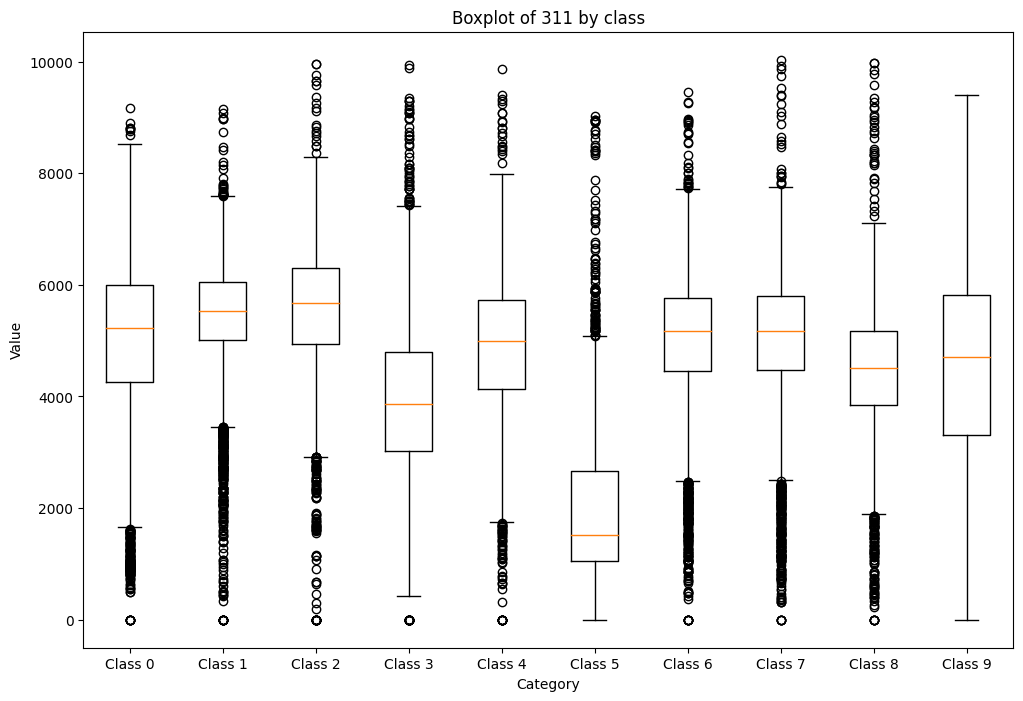

In [21]:
plt.figure(figsize=(12, 8))
boxplot_data = []
labels = []
for category, values in grouped_data_for_8.items():
    boxplot_data.append(values)
    labels.append(f'Class {int(category)}')

plt.boxplot(boxplot_data, labels=labels)
plt.title(f'Boxplot of {column} by class')
plt.xlabel('Category')
plt.ylabel('Value')
plt.show()

Т.к. предпосылки для этого теста у нас выполняются, мы вполне можем ему доверять. Давайте пройдёмся по всем признакам и для каждого проверим гипотезу о том, что номер класса не влияет на распределение признака. Чтобы убедиться в том, что тест нас не обманывает, мы посмотрим на box-plot для признака с самым большим значением p-value

In [17]:
def perform_kraskel_test(df, column_name):
    print(column_name)
    grouped_data = pd.concat([df, y_train], axis = 1).groupby('311')[column_name].apply(list)
    statistics, p_value = stats.kruskal(*grouped_data.values) 
    return statistics, p_value

p_max = -1
col_with_max_p_value = '1'
for column in df:
    if column == '311':
        continue
    
    statistics, p = perform_kraskel_test(df, column)
    if p > p_max:
        p_max = p
        col_with_max_p_value = column
        
    if p > 0.05:
        print(column)
print(col_with_max_p_value) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Тест нам говорит, что распределение каждого признака существенно зависит от принадлежности к классу. Другими словами, каждый признак согласно тесту на уровне значимости 5% влияет на жанр песни.

Давайте взглянем на обещанный box-plot. Счастливчик у нас - признак под колонкой 33

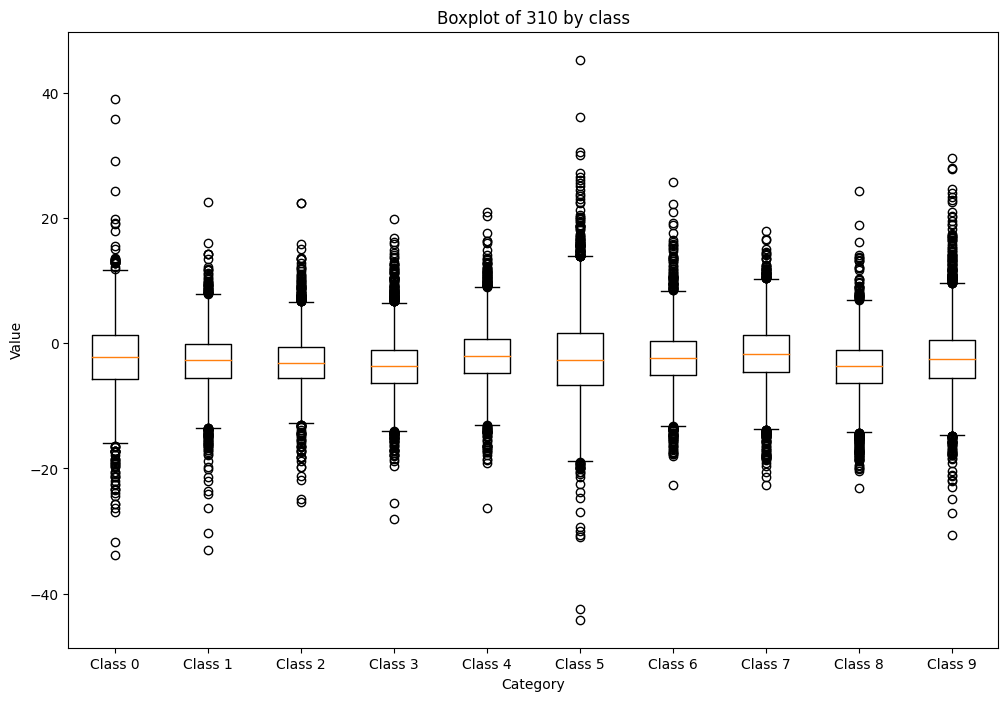

In [26]:
plt.figure(figsize=(12, 8))
boxplot_data = []
labels = []
grouped_data_for_33 = pd.concat([df, y_train], axis = 1).groupby('311')["33"].apply(list)
for category, values in grouped_data_for_33.items():
    boxplot_data.append(values)
    labels.append(f'Class {int(category)}')

plt.boxplot(boxplot_data, labels=labels)
plt.title(f'Boxplot of {column} by class')
plt.xlabel('Category')
plt.ylabel('Value')
plt.show()

В первом приближении кажется, что распределения признаков для разных классов очень похожи. Но на самом деле это не так. Распределения кажутся похожими из-за того, что IQR на графиках визуально сужается на фоне выбросов. Давайте посмотрим на квантили самого признака, а затем посмотрим на средние в разных группах, чтобы убедиться, что на фоне порядков этих квантилей средние в группах лежат достаточно далеко друг от друга и их доверительные интервалы не пересекаются.

In [27]:
q1 = np.percentile(df['33'], 25)
q3 = np.percentile(df['33'], 75)
print(f'Основной массив данных лежит от {q1} до {q3}')

Основной массив данных лежит от -5.603293418884277 до 0.21979031711816785


Будем использовать 95% доверительный интервал

Для класса 0 среднее признака составляет -2.35
95% Доверительный интервал: (-2.51, -2.19)

Для класса 1 среднее признака составляет -2.90
95% Доверительный интервал: (-3.00, -2.79)

Для класса 2 среднее признака составляет -3.04
95% Доверительный интервал: (-3.14, -2.94)

Для класса 3 среднее признака составляет -3.63
95% Доверительный интервал: (-3.75, -3.51)

Для класса 4 среднее признака составляет -1.94
95% Доверительный интервал: (-2.06, -1.83)

Для класса 5 среднее признака составляет -2.30
95% Доверительный интервал: (-2.48, -2.13)

Для класса 6 среднее признака составляет -2.42
95% Доверительный интервал: (-2.53, -2.31)

Для класса 7 среднее признака составляет -1.72
95% Доверительный интервал: (-1.86, -1.59)

Для класса 8 среднее признака составляет -3.73
95% Доверительный интервал: (-3.87, -3.60)

Для класса 9 среднее признака составляет -2.45
95% Доверительный интервал: (-2.59, -2.32)



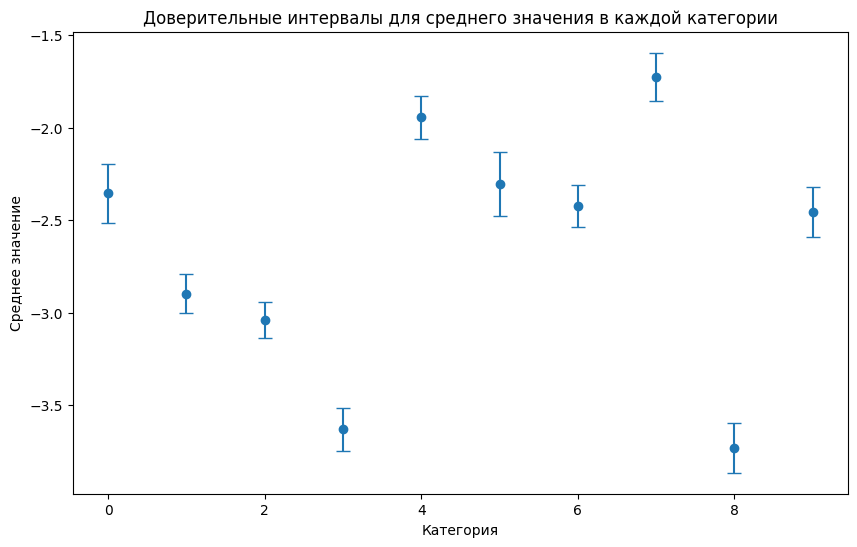

In [28]:
def compute_ci(data):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1) 
    margin_of_error = 1.96 * (std / np.sqrt(n))  
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    return ci_lower, ci_upper

ci_lower_list = []
ci_upper_list = []

for category, values in grouped_data_for_33.items():
    category = int(category)
    ci_lower, ci_upper = compute_ci(values)
    ci_lower_list.append(ci_lower)
    ci_upper_list.append(ci_upper)
    print(f'Для класса {category} среднее признака составляет {np.mean(values):.2f}')
    print(f'95% Доверительный интервал: ({ci_lower:.2f}, {ci_upper:.2f})')
    print()

plt.figure(figsize=(10, 6))
plt.errorbar(list(grouped_data_for_33.keys()), [np.mean(values) for values in grouped_data_for_33.values],
             yerr=[(ci_upper - ci_lower) / 2 for ci_upper, ci_lower in zip(ci_upper_list, ci_lower_list)],
             fmt='o', capsize=5)
plt.title('Доверительные интервалы для среднего значения в каждой категории')
plt.xlabel('Категория')
plt.ylabel('Среднее значение')
plt.show()

Как мы видим, при большем приближении различия между группами мы таки наблюдаем. Если тест Краскела — Уоллиса для признака, в котором он менее всего уверен, сработал правильно, то можно предположить, что с большой вероятностью он сработал правильно и для остальных признаков, а значит его результатам мы вполне можем доверять.

__Выводы:__ статистический анализ, целью которого была оценка влияния предикторов на целевую переменную, показал, что все признаки вносят ощутимый вклад в определении жанра музыки. Таким образом, для отбора признаков мы прибегнем к другим, нестатистическим способам, что будут рассмотрены по ходу сборки модели. 

## BASELINE

Baseline (базовый уровень) - это начальный показатель, который используется как основная точка 

In [6]:
validate = pd.read_csv('hyper.csv').drop(columns='Unnamed: 0')
validate = validate.rename(columns={'target':'311'})
valid = validate.iloc[:,:311]
y_valid = validate['311']

In [25]:
clf_for_unscaled_unprocessed_data = CatBoostClassifier()
clf_for_unscaled_unprocessed_data.fit(df, y_train)
roc_auc_score(y_valid, clf_for_unscaled_unprocessed_data.predict_proba(valid), multi_class='ovo')

Learning rate set to 0.097081
0:	learn: 2.1474580	total: 377ms	remaining: 6m 16s
1:	learn: 2.0439848	total: 653ms	remaining: 5m 26s
2:	learn: 1.9616028	total: 990ms	remaining: 5m 29s
3:	learn: 1.8951758	total: 1.27s	remaining: 5m 15s
4:	learn: 1.8382131	total: 1.62s	remaining: 5m 22s
5:	learn: 1.7885561	total: 1.99s	remaining: 5m 29s
6:	learn: 1.7459642	total: 2.28s	remaining: 5m 23s
7:	learn: 1.7066853	total: 2.58s	remaining: 5m 20s
8:	learn: 1.6702851	total: 2.83s	remaining: 5m 11s
9:	learn: 1.6377066	total: 3.2s	remaining: 5m 16s
10:	learn: 1.6057481	total: 3.48s	remaining: 5m 13s
11:	learn: 1.5804627	total: 3.77s	remaining: 5m 10s
12:	learn: 1.5581791	total: 4.04s	remaining: 5m 6s
13:	learn: 1.5377055	total: 4.35s	remaining: 5m 6s
14:	learn: 1.5164009	total: 4.74s	remaining: 5m 11s
15:	learn: 1.4924947	total: 5.05s	remaining: 5m 10s
16:	learn: 1.4700330	total: 5.38s	remaining: 5m 11s
17:	learn: 1.4498131	total: 5.7s	remaining: 5m 11s
18:	learn: 1.4317753	total: 6s	remaining: 5m 9s


158:	learn: 0.7623551	total: 44.7s	remaining: 3m 56s
159:	learn: 0.7603459	total: 45.1s	remaining: 3m 56s
160:	learn: 0.7581519	total: 45.4s	remaining: 3m 56s
161:	learn: 0.7555475	total: 45.6s	remaining: 3m 56s
162:	learn: 0.7525606	total: 45.9s	remaining: 3m 55s
163:	learn: 0.7497654	total: 46.2s	remaining: 3m 55s
164:	learn: 0.7480971	total: 46.5s	remaining: 3m 55s
165:	learn: 0.7463747	total: 46.7s	remaining: 3m 54s
166:	learn: 0.7445968	total: 47s	remaining: 3m 54s
167:	learn: 0.7429881	total: 47.3s	remaining: 3m 54s
168:	learn: 0.7407275	total: 47.5s	remaining: 3m 53s
169:	learn: 0.7383736	total: 47.8s	remaining: 3m 53s
170:	learn: 0.7366545	total: 48.1s	remaining: 3m 53s
171:	learn: 0.7345400	total: 48.4s	remaining: 3m 53s
172:	learn: 0.7330406	total: 48.7s	remaining: 3m 52s
173:	learn: 0.7314624	total: 48.9s	remaining: 3m 52s
174:	learn: 0.7292681	total: 49.2s	remaining: 3m 51s
175:	learn: 0.7277377	total: 49.4s	remaining: 3m 51s
176:	learn: 0.7249544	total: 49.7s	remaining: 3m

312:	learn: 0.5382540	total: 1m 27s	remaining: 3m 12s
313:	learn: 0.5373518	total: 1m 27s	remaining: 3m 11s
314:	learn: 0.5365181	total: 1m 28s	remaining: 3m 11s
315:	learn: 0.5359089	total: 1m 28s	remaining: 3m 11s
316:	learn: 0.5348285	total: 1m 28s	remaining: 3m 10s
317:	learn: 0.5344088	total: 1m 28s	remaining: 3m 10s
318:	learn: 0.5333475	total: 1m 29s	remaining: 3m 10s
319:	learn: 0.5323887	total: 1m 29s	remaining: 3m 9s
320:	learn: 0.5313784	total: 1m 29s	remaining: 3m 9s
321:	learn: 0.5307997	total: 1m 29s	remaining: 3m 9s
322:	learn: 0.5300698	total: 1m 30s	remaining: 3m 8s
323:	learn: 0.5290147	total: 1m 30s	remaining: 3m 8s
324:	learn: 0.5284242	total: 1m 30s	remaining: 3m 8s
325:	learn: 0.5278068	total: 1m 30s	remaining: 3m 7s
326:	learn: 0.5266191	total: 1m 31s	remaining: 3m 7s
327:	learn: 0.5258520	total: 1m 31s	remaining: 3m 7s
328:	learn: 0.5250179	total: 1m 31s	remaining: 3m 6s
329:	learn: 0.5241032	total: 1m 31s	remaining: 3m 6s
330:	learn: 0.5235749	total: 1m 32s	rem

466:	learn: 0.4280282	total: 2m 10s	remaining: 2m 28s
467:	learn: 0.4271264	total: 2m 10s	remaining: 2m 28s
468:	learn: 0.4268648	total: 2m 10s	remaining: 2m 28s
469:	learn: 0.4265099	total: 2m 11s	remaining: 2m 27s
470:	learn: 0.4259545	total: 2m 11s	remaining: 2m 27s
471:	learn: 0.4255678	total: 2m 11s	remaining: 2m 27s
472:	learn: 0.4249651	total: 2m 11s	remaining: 2m 26s
473:	learn: 0.4247541	total: 2m 12s	remaining: 2m 26s
474:	learn: 0.4244510	total: 2m 12s	remaining: 2m 26s
475:	learn: 0.4237085	total: 2m 12s	remaining: 2m 26s
476:	learn: 0.4234123	total: 2m 12s	remaining: 2m 25s
477:	learn: 0.4226917	total: 2m 13s	remaining: 2m 25s
478:	learn: 0.4222768	total: 2m 13s	remaining: 2m 25s
479:	learn: 0.4220757	total: 2m 13s	remaining: 2m 24s
480:	learn: 0.4216979	total: 2m 13s	remaining: 2m 24s
481:	learn: 0.4214417	total: 2m 14s	remaining: 2m 24s
482:	learn: 0.4212539	total: 2m 14s	remaining: 2m 23s
483:	learn: 0.4207575	total: 2m 14s	remaining: 2m 23s
484:	learn: 0.4198354	total:

619:	learn: 0.3679501	total: 2m 51s	remaining: 1m 45s
620:	learn: 0.3674023	total: 2m 51s	remaining: 1m 44s
621:	learn: 0.3671526	total: 2m 52s	remaining: 1m 44s
622:	learn: 0.3668025	total: 2m 52s	remaining: 1m 44s
623:	learn: 0.3665851	total: 2m 52s	remaining: 1m 44s
624:	learn: 0.3664058	total: 2m 52s	remaining: 1m 43s
625:	learn: 0.3660546	total: 2m 53s	remaining: 1m 43s
626:	learn: 0.3657450	total: 2m 53s	remaining: 1m 43s
627:	learn: 0.3650034	total: 2m 53s	remaining: 1m 42s
628:	learn: 0.3646305	total: 2m 53s	remaining: 1m 42s
629:	learn: 0.3644175	total: 2m 54s	remaining: 1m 42s
630:	learn: 0.3638506	total: 2m 54s	remaining: 1m 41s
631:	learn: 0.3635351	total: 2m 54s	remaining: 1m 41s
632:	learn: 0.3632965	total: 2m 54s	remaining: 1m 41s
633:	learn: 0.3629319	total: 2m 55s	remaining: 1m 41s
634:	learn: 0.3627550	total: 2m 55s	remaining: 1m 40s
635:	learn: 0.3623293	total: 2m 55s	remaining: 1m 40s
636:	learn: 0.3621230	total: 2m 55s	remaining: 1m 40s
637:	learn: 0.3617404	total:

773:	learn: 0.3204396	total: 3m 33s	remaining: 1m 2s
774:	learn: 0.3203075	total: 3m 34s	remaining: 1m 2s
775:	learn: 0.3196029	total: 3m 34s	remaining: 1m 1s
776:	learn: 0.3193966	total: 3m 34s	remaining: 1m 1s
777:	learn: 0.3191873	total: 3m 34s	remaining: 1m 1s
778:	learn: 0.3189461	total: 3m 35s	remaining: 1m 1s
779:	learn: 0.3186895	total: 3m 35s	remaining: 1m
780:	learn: 0.3183035	total: 3m 35s	remaining: 1m
781:	learn: 0.3181653	total: 3m 35s	remaining: 1m
782:	learn: 0.3180483	total: 3m 36s	remaining: 59.9s
783:	learn: 0.3179016	total: 3m 36s	remaining: 59.6s
784:	learn: 0.3177672	total: 3m 36s	remaining: 59.3s
785:	learn: 0.3176056	total: 3m 36s	remaining: 59.1s
786:	learn: 0.3174122	total: 3m 37s	remaining: 58.8s
787:	learn: 0.3172203	total: 3m 37s	remaining: 58.5s
788:	learn: 0.3170981	total: 3m 37s	remaining: 58.2s
789:	learn: 0.3169038	total: 3m 38s	remaining: 58s
790:	learn: 0.3166350	total: 3m 38s	remaining: 57.7s
791:	learn: 0.3163198	total: 3m 38s	remaining: 57.4s
792:

930:	learn: 0.2860352	total: 4m 17s	remaining: 19.1s
931:	learn: 0.2858493	total: 4m 18s	remaining: 18.8s
932:	learn: 0.2856814	total: 4m 18s	remaining: 18.6s
933:	learn: 0.2852546	total: 4m 18s	remaining: 18.3s
934:	learn: 0.2851474	total: 4m 19s	remaining: 18s
935:	learn: 0.2848898	total: 4m 19s	remaining: 17.7s
936:	learn: 0.2846681	total: 4m 19s	remaining: 17.5s
937:	learn: 0.2844424	total: 4m 19s	remaining: 17.2s
938:	learn: 0.2843614	total: 4m 20s	remaining: 16.9s
939:	learn: 0.2842190	total: 4m 20s	remaining: 16.6s
940:	learn: 0.2840943	total: 4m 20s	remaining: 16.3s
941:	learn: 0.2837211	total: 4m 20s	remaining: 16.1s
942:	learn: 0.2833811	total: 4m 21s	remaining: 15.8s
943:	learn: 0.2832953	total: 4m 21s	remaining: 15.5s
944:	learn: 0.2831625	total: 4m 21s	remaining: 15.2s
945:	learn: 0.2829736	total: 4m 22s	remaining: 15s
946:	learn: 0.2827438	total: 4m 22s	remaining: 14.7s
947:	learn: 0.2826706	total: 4m 22s	remaining: 14.4s
948:	learn: 0.2825532	total: 4m 22s	remaining: 14.

0.8318678465445187

ROC-AUC на baseline у нас 0,8318

Взглянем на важность признаков

In [26]:
d=pd.DataFrame(clf_for_unscaled_unprocessed_data.feature_names_,
             clf_for_unscaled_unprocessed_data.feature_importances_).reset_index().sort_values(by='index',ascending=False)
d.head(50)

,index,0
183,3.836423,183
184,3.820582,184
35,3.784381,35
14,3.502481,14
18,3.199494,18
56,2.925163,56
55,2.701407,55
17,2.426864,17
185,2.377303,185
0,2.240822,0


Мы вывели градацию важности признаков 

# Генерация признаков

Давайте создадим новые признаки на основе имеющихся и посмотрим, как изменится качество модели на валидационной выборке.

Для начала создадим всевозможные полиномиальные комбинации признаков 3 степени. Например, если у нас три признака x, y и z, то в новой матрице признаками будут $x$, $y$, $z$, $x^2$, $y^2$, $z^2$,$x^3$ $y^3$, $z^3$, $xy$, $xz$, $yz$, $x^2y$, $xy^2$, $x^2z$, $xz^2$, $y^2z$, $yz^2$. Получив вот эти признаки в матрице с 311 столбцами, мы по итогу получим матрицу из $145548$ признаков. Многовато, да? И это мы создали только полиномы! Не хватает чего-нибудь вкусненького. А давайте-ка от каждого признака, что мы получим в результате генерации полиномов, возьмём синус, экспоненту и корень. Тогда у нас в распоряжении окажется матрица из $436644$ признаков. Мы откажемся от изначальных полиномов в качестве отдельных признаков, и вместо них возьмём корни от полиномов, т.к. у нас много признаков кучкуется около нуля, и увеличивать разницу между значениями мы не хотим, нам наоборот бы эту разницу погасить.

Тут может возникнуть само собой напрашивающийся вопрос - что со всем этим делать? Обучать модель на сотнях тысяч признаках это а) слишком затратно по времени б) гарантировано приведёт к переобучению. Можно было бы в этой ситуации подождать недельку пока модель обучиться, затем отобрать признаки через feature importance, но это не наш путь. На помощь приходит статистика!

Давайте прибегнем к подходу, аналогичному тому, что мы использовали при оценке важности признаков в части с проверкой гипотез. Мы для каждого признака проведём тест Краскела — Уоллиса, после чего отранжируем наши признаки по значению статистики критерия, и возьмём только ту золотую тысячу признаков, в которых тест более всего уверен. Затем мы обучим модель на этих 1000 признаках и посмотрим на её качество. Чтобы снизить переобучение, мы проанилизруем встроенный в CatBoost feature_importance и отберём только самые важные признаки.

Напишем функцию, которая на вход принимают изначальную матрицу объект-признак, а на выходе выдаёт матрицу со всеми нагенерированными признаками.

In [27]:
from warnings import filterwarnings
from tqdm import tqdm
filterwarnings('ignore')
def feature_generator(df):
    X = df.copy()
    polynoms = X.apply(np.sqrt).add_suffix('_new')
    last_first_degree = polynoms.shape[1]
    for i in range(last_first_degree):
        polynoms[f'{polynoms.columns[i]}_^2'] = polynoms[polynoms.columns[i]]**2
    last_second_degree = polynoms.shape[1]
    for i in range(last_first_degree):
        polynoms[f'{polynoms.columns[i]}_^3'] = polynoms[polynoms.columns[i]]**3
    last_third_degree = polynoms.shape[1]
    map_of_xy = {}
    for i in range(last_first_degree - 1):
        for j in range(i + 1, last_first_degree):
            map_of_xy[f'{polynoms.columns[i]}_{polynoms.columns[j]}_*'] = (polynoms[polynoms.columns[i]] * polynoms[polynoms.columns[j]]).values
    map_of_xy = pd.DataFrame(map_of_xy)
    polynoms = pd.concat([polynoms, map_of_xy], axis=1)
    last_xy = polynoms.shape[1]  
    map_of_square_xy = {}
    for i in tqdm(range(last_first_degree - 1)):
        for j in range(i + 1, last_first_degree):
            map_of_square_xy[f'{polynoms.columns[i]}_{polynoms.columns[j]}_^2*'] = ((polynoms[polynoms.columns[i]]**2) * polynoms[polynoms.columns[j]]).values
            map_of_square_xy[f'{polynoms.columns[i]}_{polynoms.columns[j]}_*^2'] = (polynoms[polynoms.columns[i]] * (polynoms[polynoms.columns[j]]**2)).values    
    map_of_square_xy = pd.DataFrame(map_of_square_xy)
    polynoms = pd.concat([polynoms, map_of_square_xy], axis=1)
    sinuses = polynoms.copy(deep = True).apply(np.sin)
    sinuses = sinuses.add_suffix('_sin')
    
    exponents = polynoms.copy(deep = True).apply(np.exp)
    exponents = exponents.add_suffix('_exp')
    return pd.concat([polynoms, sinuses, exponents], axis=1)
          
    
    


В нашем датасете есть признаки, которые принимают отрицательные значения. Кроме того, у нас есть данные, которые по модулю принимают очень большие значения, а значит для таких признаков экспонента будет невалидным преобразованием т.к. значения признака будут стремиться в бесконечность. Для того, чтобы решить эти проблемы используем MIN-MAX нормировку.

Давайте перед генерацией новых признаков проверим, насколько хороша нормировка в вакууме. 

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(df))

scaled_train.columns = scaled_train.columns.astype(str)

scaled_valid = pd.DataFrame(scaler.transform(valid))
scaled_valid.columns = scaled_valid.columns.astype(str)


clf_for_scaled_unprocessed_data = CatBoostClassifier()
clf_for_scaled_unprocessed_data.fit(scaled_train, y_train)
print(roc_auc_score(y_valid, clf_for_scaled_unprocessed_data.predict_proba(scaled_valid), multi_class='ovo'))

Learning rate set to 0.097081
0:	learn: 2.1474580	total: 294ms	remaining: 4m 53s
1:	learn: 2.0439848	total: 553ms	remaining: 4m 35s
2:	learn: 1.9616028	total: 800ms	remaining: 4m 25s
3:	learn: 1.8951758	total: 1.05s	remaining: 4m 20s
4:	learn: 1.8382131	total: 1.34s	remaining: 4m 27s
5:	learn: 1.7885561	total: 1.6s	remaining: 4m 25s
6:	learn: 1.7459642	total: 1.96s	remaining: 4m 37s
7:	learn: 1.7066853	total: 2.26s	remaining: 4m 39s
8:	learn: 1.6702851	total: 2.52s	remaining: 4m 38s
9:	learn: 1.6377066	total: 2.86s	remaining: 4m 43s
10:	learn: 1.6057481	total: 3.13s	remaining: 4m 41s
11:	learn: 1.5804627	total: 3.38s	remaining: 4m 38s
12:	learn: 1.5581791	total: 3.64s	remaining: 4m 36s
13:	learn: 1.5377055	total: 3.91s	remaining: 4m 35s
14:	learn: 1.5164009	total: 4.2s	remaining: 4m 35s
15:	learn: 1.4924947	total: 4.51s	remaining: 4m 37s
16:	learn: 1.4700330	total: 4.83s	remaining: 4m 39s
17:	learn: 1.4498131	total: 5.13s	remaining: 4m 40s
18:	learn: 1.4317753	total: 5.49s	remaining: 4

157:	learn: 0.7635837	total: 46.1s	remaining: 4m 5s
158:	learn: 0.7608617	total: 46.5s	remaining: 4m 5s
159:	learn: 0.7589151	total: 46.8s	remaining: 4m 5s
160:	learn: 0.7568762	total: 47s	remaining: 4m 5s
161:	learn: 0.7547611	total: 47.3s	remaining: 4m 4s
162:	learn: 0.7522643	total: 47.7s	remaining: 4m 4s
163:	learn: 0.7509058	total: 48s	remaining: 4m 4s
164:	learn: 0.7484566	total: 48.2s	remaining: 4m 4s
165:	learn: 0.7459351	total: 48.5s	remaining: 4m 3s
166:	learn: 0.7444059	total: 48.8s	remaining: 4m 3s
167:	learn: 0.7430323	total: 49s	remaining: 4m 2s
168:	learn: 0.7412778	total: 49.3s	remaining: 4m 2s
169:	learn: 0.7396224	total: 49.6s	remaining: 4m 2s
170:	learn: 0.7378589	total: 49.9s	remaining: 4m 2s
171:	learn: 0.7362425	total: 50.2s	remaining: 4m 1s
172:	learn: 0.7348536	total: 50.5s	remaining: 4m 1s
173:	learn: 0.7335961	total: 50.8s	remaining: 4m 1s
174:	learn: 0.7314884	total: 51s	remaining: 4m
175:	learn: 0.7297279	total: 51.3s	remaining: 4m
176:	learn: 0.7270280	tota

312:	learn: 0.5373379	total: 1m 29s	remaining: 3m 16s
313:	learn: 0.5361610	total: 1m 29s	remaining: 3m 16s
314:	learn: 0.5354260	total: 1m 30s	remaining: 3m 15s
315:	learn: 0.5345601	total: 1m 30s	remaining: 3m 15s
316:	learn: 0.5337763	total: 1m 30s	remaining: 3m 15s
317:	learn: 0.5331183	total: 1m 30s	remaining: 3m 14s
318:	learn: 0.5322403	total: 1m 31s	remaining: 3m 14s
319:	learn: 0.5311014	total: 1m 31s	remaining: 3m 14s
320:	learn: 0.5304754	total: 1m 31s	remaining: 3m 13s
321:	learn: 0.5298892	total: 1m 31s	remaining: 3m 13s
322:	learn: 0.5290081	total: 1m 32s	remaining: 3m 13s
323:	learn: 0.5279373	total: 1m 32s	remaining: 3m 12s
324:	learn: 0.5271811	total: 1m 32s	remaining: 3m 12s
325:	learn: 0.5265667	total: 1m 32s	remaining: 3m 12s
326:	learn: 0.5254793	total: 1m 33s	remaining: 3m 11s
327:	learn: 0.5246490	total: 1m 33s	remaining: 3m 11s
328:	learn: 0.5238022	total: 1m 33s	remaining: 3m 11s
329:	learn: 0.5231738	total: 1m 34s	remaining: 3m 11s
330:	learn: 0.5224638	total:

466:	learn: 0.4273389	total: 2m 14s	remaining: 2m 33s
467:	learn: 0.4263828	total: 2m 14s	remaining: 2m 33s
468:	learn: 0.4261251	total: 2m 15s	remaining: 2m 32s
469:	learn: 0.4258378	total: 2m 15s	remaining: 2m 32s
470:	learn: 0.4255120	total: 2m 15s	remaining: 2m 32s
471:	learn: 0.4250271	total: 2m 15s	remaining: 2m 32s
472:	learn: 0.4243294	total: 2m 16s	remaining: 2m 31s
473:	learn: 0.4242295	total: 2m 16s	remaining: 2m 31s
474:	learn: 0.4236411	total: 2m 16s	remaining: 2m 31s
475:	learn: 0.4233638	total: 2m 17s	remaining: 2m 30s
476:	learn: 0.4229522	total: 2m 17s	remaining: 2m 30s
477:	learn: 0.4222000	total: 2m 17s	remaining: 2m 30s
478:	learn: 0.4220557	total: 2m 17s	remaining: 2m 30s
479:	learn: 0.4218571	total: 2m 18s	remaining: 2m 29s
480:	learn: 0.4214491	total: 2m 18s	remaining: 2m 29s
481:	learn: 0.4206860	total: 2m 18s	remaining: 2m 29s
482:	learn: 0.4200265	total: 2m 19s	remaining: 2m 28s
483:	learn: 0.4196232	total: 2m 19s	remaining: 2m 28s
484:	learn: 0.4185834	total:

619:	learn: 0.3686267	total: 2m 54s	remaining: 1m 46s
620:	learn: 0.3679855	total: 2m 54s	remaining: 1m 46s
621:	learn: 0.3676092	total: 2m 54s	remaining: 1m 46s
622:	learn: 0.3673027	total: 2m 55s	remaining: 1m 46s
623:	learn: 0.3670326	total: 2m 55s	remaining: 1m 45s
624:	learn: 0.3663407	total: 2m 55s	remaining: 1m 45s
625:	learn: 0.3660027	total: 2m 55s	remaining: 1m 45s
626:	learn: 0.3657279	total: 2m 56s	remaining: 1m 44s
627:	learn: 0.3650090	total: 2m 56s	remaining: 1m 44s
628:	learn: 0.3647859	total: 2m 56s	remaining: 1m 44s
629:	learn: 0.3641656	total: 2m 57s	remaining: 1m 43s
630:	learn: 0.3638219	total: 2m 57s	remaining: 1m 43s
631:	learn: 0.3633272	total: 2m 57s	remaining: 1m 43s
632:	learn: 0.3630569	total: 2m 57s	remaining: 1m 43s
633:	learn: 0.3628861	total: 2m 58s	remaining: 1m 42s
634:	learn: 0.3626802	total: 2m 58s	remaining: 1m 42s
635:	learn: 0.3624078	total: 2m 58s	remaining: 1m 42s
636:	learn: 0.3620492	total: 2m 58s	remaining: 1m 41s
637:	learn: 0.3614517	total:

772:	learn: 0.3191144	total: 3m 38s	remaining: 1m 4s
773:	learn: 0.3188920	total: 3m 39s	remaining: 1m 4s
774:	learn: 0.3187135	total: 3m 39s	remaining: 1m 3s
775:	learn: 0.3184383	total: 3m 39s	remaining: 1m 3s
776:	learn: 0.3182141	total: 3m 40s	remaining: 1m 3s
777:	learn: 0.3181322	total: 3m 40s	remaining: 1m 2s
778:	learn: 0.3178659	total: 3m 40s	remaining: 1m 2s
779:	learn: 0.3177262	total: 3m 40s	remaining: 1m 2s
780:	learn: 0.3173870	total: 3m 41s	remaining: 1m 1s
781:	learn: 0.3171059	total: 3m 41s	remaining: 1m 1s
782:	learn: 0.3169894	total: 3m 41s	remaining: 1m 1s
783:	learn: 0.3166506	total: 3m 41s	remaining: 1m 1s
784:	learn: 0.3163620	total: 3m 42s	remaining: 1m
785:	learn: 0.3161706	total: 3m 42s	remaining: 1m
786:	learn: 0.3158047	total: 3m 42s	remaining: 1m
787:	learn: 0.3156072	total: 3m 42s	remaining: 60s
788:	learn: 0.3154712	total: 3m 43s	remaining: 59.7s
789:	learn: 0.3152796	total: 3m 43s	remaining: 59.4s
790:	learn: 0.3149986	total: 3m 43s	remaining: 59.1s
791:

929:	learn: 0.2829822	total: 4m 20s	remaining: 19.6s
930:	learn: 0.2827749	total: 4m 21s	remaining: 19.4s
931:	learn: 0.2826322	total: 4m 21s	remaining: 19.1s
932:	learn: 0.2825108	total: 4m 21s	remaining: 18.8s
933:	learn: 0.2823859	total: 4m 22s	remaining: 18.5s
934:	learn: 0.2821825	total: 4m 22s	remaining: 18.2s
935:	learn: 0.2818790	total: 4m 22s	remaining: 18s
936:	learn: 0.2816051	total: 4m 23s	remaining: 17.7s
937:	learn: 0.2813166	total: 4m 23s	remaining: 17.4s
938:	learn: 0.2811348	total: 4m 23s	remaining: 17.1s
939:	learn: 0.2809306	total: 4m 23s	remaining: 16.8s
940:	learn: 0.2807297	total: 4m 24s	remaining: 16.6s
941:	learn: 0.2803319	total: 4m 24s	remaining: 16.3s
942:	learn: 0.2801581	total: 4m 24s	remaining: 16s
943:	learn: 0.2800302	total: 4m 25s	remaining: 15.7s
944:	learn: 0.2798876	total: 4m 25s	remaining: 15.4s
945:	learn: 0.2796995	total: 4m 25s	remaining: 15.2s
946:	learn: 0.2791656	total: 4m 25s	remaining: 14.9s
947:	learn: 0.2790843	total: 4m 26s	remaining: 14.

Получилось как-то очень здорово. Масштабирование, судя по-всему, приводит к потере информации признаков. Но для нашего генератора скалер необходим по причинам, озвученным чутьвыше. Давайте отмасштабируем данные, проведём тестирование и отберём 1000 лучших признаков из сгенерированных. 
В современных реализациях бустинга заложена регуляризация ответов внутри листов. Из-за применения масштабирования

К сожалению, мы не можем нагенерировать признаки из всей таблицы - ядро не выдерживают нагрузки от работы с такими большими объектами (450к признаков это не шутки). В этой связи мы будем генерировать признаки только из первых 55. Такой выбор объясняется тем, что оставшиеся 256 признаков по сути своей есть фичи, описывающие один и тот же признак, из которого мы достали столько новых данных, а первые 55 по природе своей разные.

Отмасштабируем только те признаки, по которым будет проходить генерация.

In [8]:
scaled_train_for_feats = scaled_train.iloc[:, :45]

In [24]:
def perform_kraskel_test(df, column_name):
    grouped_data = df.groupby('311')[column_name].apply(list)
    statistics, p_value = stats.kruskal(*grouped_data.values) 
    return statistics, p_value


def kraskel_test_for_table(df):
    list_of_statistics = list()
    for column in tqdm(df.columns): 
        if column == '311':
            continue 
        statistics, p = perform_kraskel_test(df, column)
        list_of_statistics.append((statistics, column))
    a = sorted(list_of_statistics,key=lambda x: x[0],reverse=True)[:1000]
    res = []
    for stat, col in a:
        res.append(col)
    return res

data_with_new_feats_scaled = feature_generator(scaled_train_for_feats)

best_feats_for_scaled_data = kraskel_test_for_table(pd.concat([data_with_new_feats_scaled, pd.DataFrame(y_train, columns = ['311'])], axis = 1))
table_with_1000_best_scaled = data_with_new_feats_scaled[best_feats_for_scaled_data]

train_scaled_with_new_feats = pd.concat([table_with_1000_best_scaled, df.iloc[:, 45:]], axis=1)

100%|███████████████████████████████████████| 9316/9316 [02:17<00:00, 67.64it/s]


Обучим модель на этих данных и посмотрим её результаты на валидационной выборке. Но перед этим подготовим саму валидационную выборку.

In [60]:
scaled_valid_for_feats = pd.concat([scaled_valid.iloc[:, :45]], axis = 1)
valid_with_new_feats_scaled = feature_generator(scaled_valid_for_feats)

table_with_1000_best_valid = valid_with_new_feats_scaled[best_feats_for_scaled_data]

valid_scaled_with_feat = pd.concat([table_with_1000_best_valid, valid.iloc[:, 45:]], axis=1)


In [61]:
clf_for_scaled_data = CatBoostClassifier()
clf_for_scaled_data.fit(train_scaled_with_feat, y_train)
print(roc_auc_score(y_valid, clf_for_scaled_data.predict_proba(valid_scaled_with_feat), multi_class='ovo'))

Learning rate set to 0.097081
0:	learn: 2.1604548	total: 1.01s	remaining: 16m 46s
1:	learn: 2.0576577	total: 1.96s	remaining: 16m 17s
2:	learn: 1.9805350	total: 2.88s	remaining: 15m 56s
3:	learn: 1.9150259	total: 3.82s	remaining: 15m 52s
4:	learn: 1.8610429	total: 4.79s	remaining: 15m 53s
5:	learn: 1.8149929	total: 5.73s	remaining: 15m 49s
6:	learn: 1.7746963	total: 6.73s	remaining: 15m 55s
7:	learn: 1.7372489	total: 7.71s	remaining: 15m 55s
8:	learn: 1.7057812	total: 8.69s	remaining: 15m 56s
9:	learn: 1.6770836	total: 9.64s	remaining: 15m 54s
10:	learn: 1.6501732	total: 10.6s	remaining: 15m 51s
11:	learn: 1.6272891	total: 11.5s	remaining: 15m 50s
12:	learn: 1.6067177	total: 12.6s	remaining: 15m 53s
13:	learn: 1.5837538	total: 13.6s	remaining: 15m 58s
14:	learn: 1.5673730	total: 14.6s	remaining: 15m 59s
15:	learn: 1.5493944	total: 15.6s	remaining: 15m 59s
16:	learn: 1.5300451	total: 16.6s	remaining: 15m 59s
17:	learn: 1.5136575	total: 17.6s	remaining: 15m 58s
18:	learn: 1.4986158	total

Результат разочаровал, он упал по сравнению с бейзлайном. Давайте посмотрим feature importance 

Мы здесь видим довольно много признаков из списка "256". Видимо, эти признаки очень важны для нашей модели. Попытавшись нагенерировать новых признаков из первых 55, мы ухудшили качество. Нужно менять подход.

Чтобы избавиться от необходиости масштабировать признаки и чтоб посмотреть на результаты преобразований признаков из списка "256" мы попробуем брать корень нечётной степени из признаков, а именно 5. В купе с экспонентой это преобразование достаточно хорошо разворачивает распределения наших признаков в что-то, что более-менее отдалёно напоминает нормальное.

<Axes: >

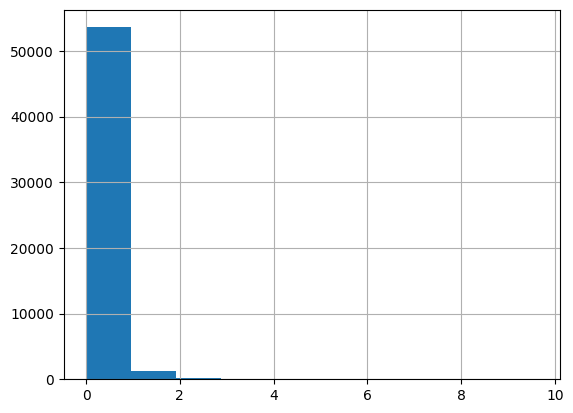

In [71]:
df['300'].hist()

Не очень приятно, да? А давайте взглянем на корень 2 степени. Сможет ли это преобразование оттянуть распределение от нуля?

<Axes: >

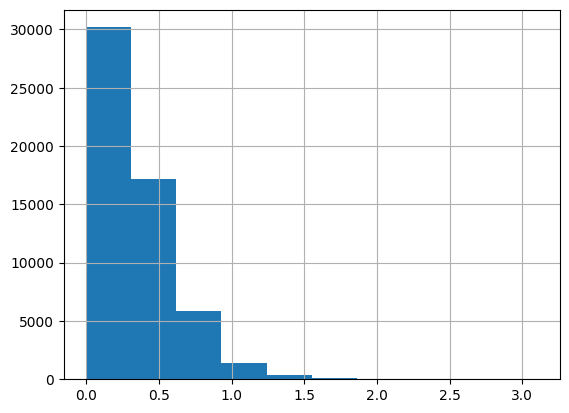

In [72]:
(df['300'] ** (1/2)).hist()

Что-то получилось, но как-будто бы недостаточно. Тут на помощь и приходит корень 5 степени. Взгляните на это

<Axes: >

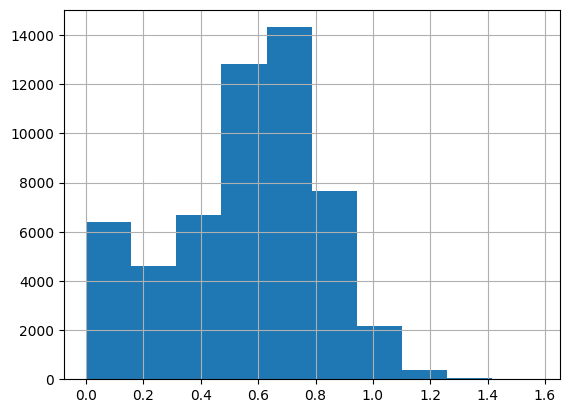

In [73]:
(df['300'] ** (1/5)).hist()

Ранее мы мы брали первые 55 признаков, масштабировали их, генерировали из них новые признаки (в т.ч. те, что повторяли изначально имеющиеся 55, т.е. те, что получались после того как мы брали корень от признака, а затем возводили его в квадрат), конкетировали новую матрицу обеъект-признак с оставшимися 256 признаками и обучались на этом датасете. 


Теперь мы откажемся от масштабирования, и чтобы симитировать те его свойства, что нужны для корректной работы генератора, мы будем брать корень 5 степени от данных. Для этого чутка изменим функцию генератор. Так же теперь мы будем генерировать новые признаки не из первых 55, а из 65 лучших признаков по feature importance нашего бейзлайна.

Напишем функцию, которая берёт отрицательную нечётную степень

In [30]:
def kth_root(x,k = 5):
    if k % 2 != 0:
        res = np.power(np.abs(x),1./k)
        return res*np.sign(x)
    else:
        return np.power(np.abs(x),1./k)
    
kth_root(-5)

-1.379729661461215

In [31]:
filterwarnings('ignore')
def feature_generator_non_scaled(df):
    X = df.copy()
    polynoms = X.copy(deep = True).apply(kth_root).add_suffix('_new')
    last_first_degree = polynoms.shape[1]
    for i in range(last_first_degree):
        polynoms[f'{polynoms.columns[i]}_^2'] = polynoms[polynoms.columns[i]]**2
    last_second_degree = polynoms.shape[1]
    for i in range(last_first_degree):
        polynoms[f'{polynoms.columns[i]}_^3'] = polynoms[polynoms.columns[i]]**3
    last_third_degree = polynoms.shape[1]
    map_of_xy = {}
    for i in range(last_first_degree - 1):
        for j in range(i + 1, last_first_degree):
            map_of_xy[f'{polynoms.columns[i]}_{polynoms.columns[j]}_*'] = (polynoms[polynoms.columns[i]] * polynoms[polynoms.columns[j]]).values
    map_of_xy = pd.DataFrame(map_of_xy)
    polynoms = pd.concat([polynoms, map_of_xy], axis=1)
    last_xy = polynoms.shape[1] 
    map_of_square_xy = {}
    for i in tqdm(range(last_first_degree - 1)):
        for j in range(i + 1, last_first_degree):
            map_of_square_xy[f'{polynoms.columns[i]}_{polynoms.columns[j]}_^2*'] = ((polynoms[polynoms.columns[i]]**2) * polynoms[polynoms.columns[j]]).values
            map_of_square_xy[f'{polynoms.columns[i]}_{polynoms.columns[j]}_*^2'] = (polynoms[polynoms.columns[i]] * (polynoms[polynoms.columns[j]]**2)).values    
    map_of_square_xy = pd.DataFrame(map_of_square_xy)
    polynoms = pd.concat([polynoms, map_of_square_xy], axis=1)
    sinuses = polynoms.apply(np.sin)
    sinuses = sinuses.add_suffix('_sin')
    
    exponents = polynoms.apply(np.exp)
    exponents = exponents.add_suffix('_exp')
    
    return pd.concat([polynoms, sinuses, exponents], axis=1)



Ищем 65 лучших признаков по версии катбуста (65 - максимальное число, выше которого ядро умирает)

In [32]:
base_feats = pd.DataFrame(clf_for_unscaled_unprocessed_data.feature_names_,
             clf_for_unscaled_unprocessed_data.feature_importances_).reset_index().sort_values(by='index',ascending=False)
top_45_columns = d[0].to_list()[:45]


Готовим трейн и валидационную выборку. Они будут состоять из 1000 нагенерированных признаков плюс 311 изначальных.

In [34]:
train_for_feats = df[top_45_columns]
data_with_new_feats_non_scaled = feature_generator_non_scaled(train_for_feats)
best_feats_for_data = kraskel_test_for_table(pd.concat([data_with_new_feats_non_scaled, pd.DataFrame(y_train, columns = ['311'])], axis = 1))

table_with_1000_best = data_with_new_feats_non_scaled[best_feats_for_data]

train_with_feat = pd.concat([table_with_1000_best, df], axis=1)
                      

100%|███████████████████████████████████████| 9316/9316 [02:10<00:00, 71.22it/s]


In [35]:
valid_for_feats = valid[top_45_columns]
valid_with_new_feats = feature_generator_non_scaled(valid_for_feats)
table_with_1000_best_valid = valid_with_new_feats[best_feats_for_data]
valid_with_feat = pd.concat([table_with_1000_best_valid, valid], axis=1)

100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 170.32it/s]


In [36]:
clf_for_data = CatBoostClassifier()
clf_for_data.fit(train_with_feat, y_train)
print(roc_auc_score(y_valid, clf_for_data.predict_proba(valid_with_feat), multi_class='ovo'))

Learning rate set to 0.097081
0:	learn: 2.1421345	total: 1.06s	remaining: 17m 35s
1:	learn: 2.0287915	total: 2.19s	remaining: 18m 12s
2:	learn: 1.9413564	total: 3.21s	remaining: 17m 48s
3:	learn: 1.8733803	total: 4.2s	remaining: 17m 25s
4:	learn: 1.8129963	total: 5.21s	remaining: 17m 17s
5:	learn: 1.7623853	total: 6.22s	remaining: 17m 10s
6:	learn: 1.7214073	total: 7.2s	remaining: 17m 1s
7:	learn: 1.6789073	total: 8.23s	remaining: 17m
8:	learn: 1.6444251	total: 9.21s	remaining: 16m 54s
9:	learn: 1.6142584	total: 10.2s	remaining: 16m 48s
10:	learn: 1.5880238	total: 11.2s	remaining: 16m 46s
11:	learn: 1.5590564	total: 12.3s	remaining: 16m 53s
12:	learn: 1.5314500	total: 13.4s	remaining: 16m 54s
13:	learn: 1.5111950	total: 14.4s	remaining: 16m 51s
14:	learn: 1.4897177	total: 15.5s	remaining: 16m 56s
15:	learn: 1.4687010	total: 16.5s	remaining: 16m 56s
16:	learn: 1.4510131	total: 17.6s	remaining: 16m 54s
17:	learn: 1.4351382	total: 18.6s	remaining: 16m 53s
18:	learn: 1.4193013	total: 19.8s

153:	learn: 0.7802216	total: 3m 2s	remaining: 16m 42s
154:	learn: 0.7778470	total: 3m 3s	remaining: 16m 41s
155:	learn: 0.7748417	total: 3m 5s	remaining: 16m 40s
156:	learn: 0.7732149	total: 3m 6s	remaining: 16m 39s
157:	learn: 0.7697641	total: 3m 7s	remaining: 16m 38s
158:	learn: 0.7674484	total: 3m 8s	remaining: 16m 37s
159:	learn: 0.7653786	total: 3m 9s	remaining: 16m 36s
160:	learn: 0.7635524	total: 3m 10s	remaining: 16m 34s
161:	learn: 0.7620754	total: 3m 11s	remaining: 16m 33s
162:	learn: 0.7595360	total: 3m 13s	remaining: 16m 31s
163:	learn: 0.7571356	total: 3m 14s	remaining: 16m 29s
164:	learn: 0.7550106	total: 3m 15s	remaining: 16m 27s
165:	learn: 0.7522932	total: 3m 16s	remaining: 16m 26s
166:	learn: 0.7503828	total: 3m 17s	remaining: 16m 25s
167:	learn: 0.7485155	total: 3m 18s	remaining: 16m 23s
168:	learn: 0.7458703	total: 3m 19s	remaining: 16m 22s
169:	learn: 0.7442351	total: 3m 21s	remaining: 16m 21s
170:	learn: 0.7424433	total: 3m 22s	remaining: 16m 20s
171:	learn: 0.740

303:	learn: 0.5556794	total: 5m 55s	remaining: 13m 34s
304:	learn: 0.5539915	total: 5m 56s	remaining: 13m 33s
305:	learn: 0.5530591	total: 5m 58s	remaining: 13m 32s
306:	learn: 0.5522623	total: 5m 59s	remaining: 13m 30s
307:	learn: 0.5513584	total: 6m	remaining: 13m 29s
308:	learn: 0.5505420	total: 6m 1s	remaining: 13m 27s
309:	learn: 0.5495281	total: 6m 2s	remaining: 13m 26s
310:	learn: 0.5482811	total: 6m 3s	remaining: 13m 25s
311:	learn: 0.5476148	total: 6m 4s	remaining: 13m 23s
312:	learn: 0.5466650	total: 6m 5s	remaining: 13m 22s
313:	learn: 0.5461002	total: 6m 6s	remaining: 13m 20s
314:	learn: 0.5447535	total: 6m 7s	remaining: 13m 19s
315:	learn: 0.5441605	total: 6m 8s	remaining: 13m 18s
316:	learn: 0.5430738	total: 6m 9s	remaining: 13m 16s
317:	learn: 0.5422466	total: 6m 10s	remaining: 13m 15s
318:	learn: 0.5412241	total: 6m 11s	remaining: 13m 13s
319:	learn: 0.5403362	total: 6m 12s	remaining: 13m 12s
320:	learn: 0.5394422	total: 6m 13s	remaining: 13m 10s
321:	learn: 0.5385782	t

454:	learn: 0.4420821	total: 8m 41s	remaining: 10m 24s
455:	learn: 0.4417645	total: 8m 42s	remaining: 10m 23s
456:	learn: 0.4411853	total: 8m 43s	remaining: 10m 22s
457:	learn: 0.4408844	total: 8m 44s	remaining: 10m 20s
458:	learn: 0.4405934	total: 8m 45s	remaining: 10m 19s
459:	learn: 0.4401203	total: 8m 46s	remaining: 10m 18s
460:	learn: 0.4394373	total: 8m 47s	remaining: 10m 17s
461:	learn: 0.4390948	total: 8m 49s	remaining: 10m 16s
462:	learn: 0.4387166	total: 8m 50s	remaining: 10m 14s
463:	learn: 0.4382375	total: 8m 51s	remaining: 10m 13s
464:	learn: 0.4377073	total: 8m 52s	remaining: 10m 12s
465:	learn: 0.4374121	total: 8m 53s	remaining: 10m 11s
466:	learn: 0.4371206	total: 8m 54s	remaining: 10m 10s
467:	learn: 0.4366222	total: 8m 55s	remaining: 10m 9s
468:	learn: 0.4355164	total: 8m 56s	remaining: 10m 7s
469:	learn: 0.4351995	total: 8m 57s	remaining: 10m 6s
470:	learn: 0.4340797	total: 8m 59s	remaining: 10m 5s
471:	learn: 0.4331054	total: 9m	remaining: 10m 4s
472:	learn: 0.43247

606:	learn: 0.3728191	total: 11m 28s	remaining: 7m 25s
607:	learn: 0.3726894	total: 11m 29s	remaining: 7m 24s
608:	learn: 0.3724585	total: 11m 30s	remaining: 7m 23s
609:	learn: 0.3721981	total: 11m 31s	remaining: 7m 22s
610:	learn: 0.3718988	total: 11m 32s	remaining: 7m 21s
611:	learn: 0.3712431	total: 11m 33s	remaining: 7m 19s
612:	learn: 0.3705977	total: 11m 35s	remaining: 7m 18s
613:	learn: 0.3703245	total: 11m 36s	remaining: 7m 17s
614:	learn: 0.3701493	total: 11m 37s	remaining: 7m 16s
615:	learn: 0.3696561	total: 11m 38s	remaining: 7m 15s
616:	learn: 0.3692225	total: 11m 39s	remaining: 7m 14s
617:	learn: 0.3682549	total: 11m 41s	remaining: 7m 13s
618:	learn: 0.3678815	total: 11m 42s	remaining: 7m 12s
619:	learn: 0.3676038	total: 11m 43s	remaining: 7m 11s
620:	learn: 0.3674305	total: 11m 44s	remaining: 7m 9s
621:	learn: 0.3669528	total: 11m 45s	remaining: 7m 8s
622:	learn: 0.3665019	total: 11m 46s	remaining: 7m 7s
623:	learn: 0.3662379	total: 11m 47s	remaining: 7m 6s
624:	learn: 0.

757:	learn: 0.3252532	total: 14m 20s	remaining: 4m 34s
758:	learn: 0.3250835	total: 14m 21s	remaining: 4m 33s
759:	learn: 0.3247440	total: 14m 22s	remaining: 4m 32s
760:	learn: 0.3243053	total: 14m 23s	remaining: 4m 31s
761:	learn: 0.3241688	total: 14m 24s	remaining: 4m 30s
762:	learn: 0.3238551	total: 14m 25s	remaining: 4m 28s
763:	learn: 0.3234294	total: 14m 26s	remaining: 4m 27s
764:	learn: 0.3232732	total: 14m 28s	remaining: 4m 26s
765:	learn: 0.3230655	total: 14m 29s	remaining: 4m 25s
766:	learn: 0.3227279	total: 14m 30s	remaining: 4m 24s
767:	learn: 0.3225866	total: 14m 31s	remaining: 4m 23s
768:	learn: 0.3223386	total: 14m 32s	remaining: 4m 22s
769:	learn: 0.3220201	total: 14m 33s	remaining: 4m 21s
770:	learn: 0.3217951	total: 14m 35s	remaining: 4m 19s
771:	learn: 0.3216068	total: 14m 36s	remaining: 4m 18s
772:	learn: 0.3214756	total: 14m 37s	remaining: 4m 17s
773:	learn: 0.3210554	total: 14m 38s	remaining: 4m 16s
774:	learn: 0.3203247	total: 14m 39s	remaining: 4m 15s
775:	learn

908:	learn: 0.2908390	total: 18m 9s	remaining: 1m 49s
909:	learn: 0.2906018	total: 18m 11s	remaining: 1m 47s
910:	learn: 0.2904397	total: 18m 13s	remaining: 1m 46s
911:	learn: 0.2903119	total: 18m 15s	remaining: 1m 45s
912:	learn: 0.2901063	total: 18m 17s	remaining: 1m 44s
913:	learn: 0.2899166	total: 18m 19s	remaining: 1m 43s
914:	learn: 0.2896055	total: 18m 21s	remaining: 1m 42s
915:	learn: 0.2894924	total: 18m 23s	remaining: 1m 41s
916:	learn: 0.2893640	total: 18m 25s	remaining: 1m 40s
917:	learn: 0.2891766	total: 18m 27s	remaining: 1m 38s
918:	learn: 0.2890488	total: 18m 29s	remaining: 1m 37s
919:	learn: 0.2887917	total: 18m 31s	remaining: 1m 36s
920:	learn: 0.2885915	total: 18m 33s	remaining: 1m 35s
921:	learn: 0.2883390	total: 18m 35s	remaining: 1m 34s
922:	learn: 0.2881096	total: 18m 37s	remaining: 1m 33s
923:	learn: 0.2878456	total: 18m 39s	remaining: 1m 32s
924:	learn: 0.2877961	total: 18m 41s	remaining: 1m 30s
925:	learn: 0.2877000	total: 18m 43s	remaining: 1m 29s
926:	learn:

Неплохо. Но всё же хуже по сравнению с бейзлайном. Скорее всего модель переобучилась. Давайте используем топ 500 по важности признаков

In [46]:
feats_top = pd.DataFrame(clf_for_data.feature_names_,clf_for_data.feature_importances_).reset_index().sort_values(by='index',ascending=False)

Возможно, модель переобучилась. Используем только 500 лучших признаков. 

In [41]:
top_feats_500 = feats_top.iloc[:500, 1].to_list()

train_with_top_feats_500 = train_with_feat[top_feats_500]
valid_with_top_feats_500 = valid_with_feat[top_feats_500]
cat_boost_with_top_500 = CatBoostClassifier()
cat_boost_with_top_500.fit(train_with_top_feats_500, y_train)
print(roc_auc_score(y_valid, cat_boost_with_top_500.predict_proba(valid_with_top_feats_500), multi_class='ovo'))

Learning rate set to 0.097081
0:	learn: 2.1433944	total: 435ms	remaining: 7m 14s
1:	learn: 2.0277430	total: 749ms	remaining: 6m 13s
2:	learn: 1.9422306	total: 1.06s	remaining: 5m 53s
3:	learn: 1.8709863	total: 1.37s	remaining: 5m 41s
4:	learn: 1.8139783	total: 1.67s	remaining: 5m 31s
5:	learn: 1.7639922	total: 1.98s	remaining: 5m 28s
6:	learn: 1.7199511	total: 2.27s	remaining: 5m 21s
7:	learn: 1.6809339	total: 2.54s	remaining: 5m 15s
8:	learn: 1.6435356	total: 2.86s	remaining: 5m 14s
9:	learn: 1.6109624	total: 3.13s	remaining: 5m 9s
10:	learn: 1.5840500	total: 3.39s	remaining: 5m 4s
11:	learn: 1.5563700	total: 3.7s	remaining: 5m 4s
12:	learn: 1.5293131	total: 3.96s	remaining: 5m 1s
13:	learn: 1.5061491	total: 4.25s	remaining: 4m 59s
14:	learn: 1.4841772	total: 4.53s	remaining: 4m 57s
15:	learn: 1.4643917	total: 4.81s	remaining: 4m 55s
16:	learn: 1.4450118	total: 5.18s	remaining: 4m 59s
17:	learn: 1.4283199	total: 5.58s	remaining: 5m 4s
18:	learn: 1.4100454	total: 5.85s	remaining: 5m 2s

Качество повысилось. Действительно, модель с 1300+ признаками была переобучена. Метдом проб и ошибок мы выяснили, что оптимальное количество признаков для нас в этой ситуации - 350. Столько и возьмём.

In [59]:
top_feats = feats_top.iloc[:400, 1].to_list()


,index,0
1014,3.261785,14
1018,2.790231,18
1017,2.531104,17
1000,1.517263,0
1020,1.261359,20
...,...,...
815,0.000000,184_new_3_new_*_201_new_^2*_exp
359,0.000000,56_new_285_new_*_201_new_^2*_exp
358,0.000000,56_new_285_new_*_201_new_^2*
819,0.000000,40_new_181_new_*_201_new_^2*_exp


In [ ]:
top_feats_350 = feats_top.iloc[:350, 1].to_list()

train_with_top_feats_350 = train_with_feat[top_feats_350]
valid_with_top_feats_350 = valid_with_feat[top_feats_350]
cat_boost_with_top_350 = CatBoostClassifier()
cat_boost_with_top_350.fit(train_with_top_feats_350, y_train)
print(roc_auc_score(y_valid, cat_boost_with_top_350.predict_proba(valid_with_top_feats_350), multi_class='ovo'))

Learning rate set to 0.097081
0:	learn: 2.1518283	total: 318ms	remaining: 5m 17s
1:	learn: 2.0419642	total: 586ms	remaining: 4m 52s
2:	learn: 1.9514765	total: 852ms	remaining: 4m 43s
3:	learn: 1.8834395	total: 1.14s	remaining: 4m 45s
4:	learn: 1.8201553	total: 1.45s	remaining: 4m 48s
5:	learn: 1.7665542	total: 1.72s	remaining: 4m 44s
6:	learn: 1.7245952	total: 2.02s	remaining: 4m 46s
7:	learn: 1.6851191	total: 2.3s	remaining: 4m 44s
8:	learn: 1.6536789	total: 2.64s	remaining: 4m 50s
9:	learn: 1.6201184	total: 2.99s	remaining: 4m 56s
10:	learn: 1.5900059	total: 3.29s	remaining: 4m 55s
11:	learn: 1.5621376	total: 3.6s	remaining: 4m 56s
12:	learn: 1.5365084	total: 3.9s	remaining: 4m 56s
13:	learn: 1.5122279	total: 4.21s	remaining: 4m 56s
14:	learn: 1.4892020	total: 4.49s	remaining: 4m 55s
15:	learn: 1.4692551	total: 4.8s	remaining: 4m 55s
16:	learn: 1.4505679	total: 5.09s	remaining: 4m 54s
17:	learn: 1.4326006	total: 5.38s	remaining: 4m 53s
18:	learn: 1.4152480	total: 5.66s	remaining: 4m 

In [61]:
350 - 0,8323

(400, 8314)

Итак, мы выбили качество, что бьёт бейзлайн. Честно говоря, мы ожидали большего, и потому нас ситуация пока не устраивает.

Наша гипотеза заключается в том, что качество улучшается не сильно из-за плохой способностьи нашей эвристической функции отсеивания выбирать фичи. Давайте попробуем обучить модель добавив только корни пятой степени с экспонентами к основным признакам

In [38]:
def add_sqrt_exp(df):
    X = df.copy()
    X_exp_sqrt = X.apply(lambda x: np.exp(kth_root(x)))
    X_exp_sqrt = X_exp_sqrt.add_suffix('_exp_sqrt')
    return pd.concat([X, X_exp_sqrt], axis = 1)

train_with_cool_feats = add_sqrt_exp(df)
valid_with_cool_feats = add_sqrt_exp(valid)

cat_boost_with_exp = CatBoostClassifier()
cat_boost_with_exp.fit(train_with_cool_feats, y_train)
print(roc_auc_score(y_valid, cat_boost_with_exp.predict_proba(valid_with_cool_feats), multi_class='ovo'))



    
    
    

Learning rate set to 0.097081
0:	learn: 2.1545486	total: 537ms	remaining: 8m 56s
1:	learn: 2.0466127	total: 1.01s	remaining: 8m 23s
2:	learn: 1.9626353	total: 1.55s	remaining: 8m 34s
3:	learn: 1.8985898	total: 2.02s	remaining: 8m 23s
4:	learn: 1.8409275	total: 2.5s	remaining: 8m 16s
5:	learn: 1.7903629	total: 2.97s	remaining: 8m 12s
6:	learn: 1.7443796	total: 3.44s	remaining: 8m 8s
7:	learn: 1.6992395	total: 3.91s	remaining: 8m 4s
8:	learn: 1.6646276	total: 4.37s	remaining: 8m 1s
9:	learn: 1.6342647	total: 4.83s	remaining: 7m 58s
10:	learn: 1.6064695	total: 5.29s	remaining: 7m 56s
11:	learn: 1.5807373	total: 5.76s	remaining: 7m 54s
12:	learn: 1.5532071	total: 6.23s	remaining: 7m 52s
13:	learn: 1.5313679	total: 6.7s	remaining: 7m 51s
14:	learn: 1.5087423	total: 7.17s	remaining: 7m 50s
15:	learn: 1.4881389	total: 7.64s	remaining: 7m 49s
16:	learn: 1.4677119	total: 8.1s	remaining: 7m 48s
17:	learn: 1.4478209	total: 8.6s	remaining: 7m 49s
18:	learn: 1.4297667	total: 9.16s	remaining: 7m 52s

In [58]:
Качество снизили

0.8309960223803189


К сожалению, качество не повысилось. Попробуем еще две идеи. Сначала посмотрим на важность признаков и попробуем избавиться от части признаков, которые могли привести к переобучению.

In [70]:
feats_with_exp_top = pd.DataFrame(cat_boost_with_exp.feature_names_,cat_boost_with_exp.feature_importances_).reset_index()
feats_with_exp_top.sort_values(by='index',ascending=True).head()

,index,0
409,0.0,98_exp_sqrt
568,0.0,257_exp_sqrt
472,0.0,161_exp_sqrt
473,0.0,162_exp_sqrt
566,0.0,255_exp_sqrt


Мы видим много бесполезных признаков. Давайте обучимся только на тех признаках, для которых feature importance составила больше, чем 0.05

In [75]:
cols = feats_with_exp_top.loc[feats_with_exp_top['index'] > 0.05, [0]][0].to_list()
train_with_cool_feats_processed = train_with_cool_feats[cols]
valid_with_cool_feats_processed = valid_with_cool_feats[cols]
cat_boost_with_exp_processed = CatBoostClassifier()
cat_boost_with_exp_processed.fit(train_with_cool_feats_processed, y_train)
print(roc_auc_score(y_valid, cat_boost_with_exp_processed.predict_proba(valid_with_cool_feats_processed), multi_class='ovo'))

Learning rate set to 0.097081
0:	learn: 2.1489529	total: 278ms	remaining: 4m 37s
1:	learn: 2.0430541	total: 544ms	remaining: 4m 31s
2:	learn: 1.9673347	total: 796ms	remaining: 4m 24s
3:	learn: 1.8980847	total: 1.05s	remaining: 4m 20s
4:	learn: 1.8407345	total: 1.3s	remaining: 4m 18s
5:	learn: 1.7931849	total: 1.55s	remaining: 4m 16s
6:	learn: 1.7488698	total: 1.8s	remaining: 4m 15s
7:	learn: 1.7101874	total: 2.11s	remaining: 4m 21s
8:	learn: 1.6705880	total: 2.36s	remaining: 4m 19s
9:	learn: 1.6388503	total: 2.61s	remaining: 4m 18s
10:	learn: 1.6053093	total: 2.86s	remaining: 4m 17s
11:	learn: 1.5747091	total: 3.11s	remaining: 4m 16s
12:	learn: 1.5480941	total: 3.4s	remaining: 4m 18s
13:	learn: 1.5207407	total: 3.68s	remaining: 4m 19s
14:	learn: 1.4955068	total: 3.94s	remaining: 4m 19s
15:	learn: 1.4750254	total: 4.24s	remaining: 4m 20s
16:	learn: 1.4584994	total: 4.53s	remaining: 4m 22s
17:	learn: 1.4401975	total: 4.81s	remaining: 4m 22s
18:	learn: 1.4232557	total: 5.07s	remaining: 4m

###Избавление от части признаков привело к снижению качества модели. Нужно придумывать что-то ещё.

Попробуем измениить подход к генерацию. Если мы посмотрим на feature importance прошлых моделей с нагенерированными признаками, мы заметим, что там в том числе были признаки, основанные на перемножениях. К сожалению, комбинаций перемножений наших признаков слишком много, чтобы обучаться на всевозможных комбинациях от нашей изначальной матрицы объект-признак. Давайте попробуем взять только 30 самых важных признаков бейзлайна и нагенерировать новые исключительно от них, а затем все новые признаки добавим в табличку. Тем самым мы избавимся от необходимости использовать эвристический метод оценки важности признаков, и важность будет определяться уже непосредственно самой моделью. Чтобы уменьшить количество столбцов, мы исключим признаки, завязанные на перемножении квадрата одного признака на другой признак ($x^2y$ или $xy^2$)

In [59]:
def feature_generator_new(X):
    polynoms = X.apply(kth_root).add_suffix('_new')
    last_first_degree = polynoms.shape[1]
    
    for i in range(last_first_degree):
        polynoms[f'{polynoms.columns[i]}_^2/5'] = polynoms[polynoms.columns[i]]**2
    last_second_degree = polynoms.shape[1]
    for i in range(last_first_degree):
        polynoms[f'{polynoms.columns[i]}_^3/5'] = polynoms[polynoms.columns[i]]**3
    last_third_degree = polynoms.shape[1]
    map_of_xy = {}
    for i in range(last_first_degree - 1):
        for j in range(i + 1, last_first_degree):
            map_of_xy[f'{polynoms.columns[i]}_{polynoms.columns[j]}_*_sqrt(5)'] = (polynoms[polynoms.columns[i]] * polynoms[polynoms.columns[j]]).values
    map_of_xy = pd.DataFrame(map_of_xy)
    polynoms = pd.concat([polynoms, map_of_xy], axis=1)  
    sinuses = polynoms.apply(np.sin)
    sinuses = sinuses.add_suffix('_sin')
    
    exponents = polynoms.apply(np.exp)
    exponents = exponents.add_suffix('_exp')
    return pd.concat([polynoms, sinuses, exponents], axis=1)
top_30_columns = d[0].to_list()[:30]


In [60]:
train_f =  pd.concat([df, feature_generator_new(df[top_30_columns])], axis = 1)
valid_f = pd.concat([valid, feature_generator_new(valid[top_30_columns])], axis = 1)
cat_boost_with_processed_30 = CatBoostClassifier()
cat_boost_with_processed_30.fit(train_f, y_train)
print(roc_auc_score(y_valid, cat_boost_with_processed_30.predict_proba(valid_f), multi_class='ovo'))                     

Learning rate set to 0.097081
0:	learn: 2.1466635	total: 1.48s	remaining: 24m 42s
1:	learn: 2.0303281	total: 2.95s	remaining: 24m 30s
2:	learn: 1.9466270	total: 4.36s	remaining: 24m 8s
3:	learn: 1.8755710	total: 5.87s	remaining: 24m 22s
4:	learn: 1.8107002	total: 7.41s	remaining: 24m 33s
5:	learn: 1.7566292	total: 8.84s	remaining: 24m 23s
6:	learn: 1.7081213	total: 10.4s	remaining: 24m 32s
7:	learn: 1.6693295	total: 11.8s	remaining: 24m 26s
8:	learn: 1.6315827	total: 13.3s	remaining: 24m 24s
9:	learn: 1.5932313	total: 14.8s	remaining: 24m 24s
10:	learn: 1.5603072	total: 16.3s	remaining: 24m 27s
11:	learn: 1.5280794	total: 17.8s	remaining: 24m 28s
12:	learn: 1.4997845	total: 19.3s	remaining: 24m 26s
13:	learn: 1.4745982	total: 20.8s	remaining: 24m 26s
14:	learn: 1.4528231	total: 22.3s	remaining: 24m 25s
15:	learn: 1.4302841	total: 23.8s	remaining: 24m 25s
16:	learn: 1.4113990	total: 25.4s	remaining: 24m 26s
17:	learn: 1.3889603	total: 26.9s	remaining: 24m 26s
18:	learn: 1.3715966	total:

Качество довольно таки низкое. Модель переобучилась. Отсеям часть признаков.

In [62]:
feats_top = pd.DataFrame(cat_boost_with_processed_30.feature_names_,cat_boost_with_processed_30.feature_importances_).reset_index()
feats_top.sort_values(by='index',ascending=False).head()

,index,0
899,2.216394,14_new_^3/5_sin
313,0.920007,35_new
1075,0.881371,56_new_1_new_*_sqrt(5)_sin
441,0.862615,184_new_3_new_*_sqrt(5)
37,0.802091,37


In [63]:
top_feats = feats_top.loc[feats_top['index'] > 0.1, [0]][0].to_list()

train_with_top_feats = train_f[top_feats]
valid_with_top_feats = valid_f[top_feats]
cat_boost_with_top = CatBoostClassifier()
cat_boost_with_top.fit(train_with_top_feats, y_train)
print(roc_auc_score(y_valid, cat_boost_with_top.predict_proba(valid_with_top_feats), multi_class='ovo'))

Learning rate set to 0.097081
0:	learn: 2.1380104	total: 258ms	remaining: 4m 17s
1:	learn: 2.0234211	total: 558ms	remaining: 4m 38s
2:	learn: 1.9421362	total: 778ms	remaining: 4m 18s
3:	learn: 1.8656080	total: 998ms	remaining: 4m 8s
4:	learn: 1.8046389	total: 1.22s	remaining: 4m 2s
5:	learn: 1.7526065	total: 1.43s	remaining: 3m 57s
6:	learn: 1.7062565	total: 1.66s	remaining: 3m 55s
7:	learn: 1.6605670	total: 1.98s	remaining: 4m 6s
8:	learn: 1.6223477	total: 2.29s	remaining: 4m 12s
9:	learn: 1.5877444	total: 2.59s	remaining: 4m 16s
10:	learn: 1.5557420	total: 2.81s	remaining: 4m 12s
11:	learn: 1.5256183	total: 3.03s	remaining: 4m 9s
12:	learn: 1.4975714	total: 3.25s	remaining: 4m 6s
13:	learn: 1.4738610	total: 3.48s	remaining: 4m 5s
14:	learn: 1.4527754	total: 3.73s	remaining: 4m 4s
15:	learn: 1.4302733	total: 3.94s	remaining: 4m 2s
16:	learn: 1.4102564	total: 4.18s	remaining: 4m 2s
17:	learn: 1.3912796	total: 4.4s	remaining: 3m 59s
18:	learn: 1.3743019	total: 4.61s	remaining: 3m 58s
19

Качество только снизилось в результате отбора признаков датафрейма последней версии. Скорее всего генерация пошла в неправильное русло. Думаю, пришло время остановиться, поскольку, как оказалось, пробить бейзлейн очень тяжёло. На данный момент лучшая версия датафрейма заключена в train_with_top_feats_350 и valid_with_top_feats_350, а признаки лежат в top_feats_350. Их и будем использовать в дальнейшем. 

Файл и так перегружен, поэтому вторую часть работы с моделью мы поместим в новую тетрадь. Здесь выгрузим итоговые датасеты после секции feature engineering.

In [ ]:
train_with_top_feats_350.to_csv('train_with_top_feats_350.csv')
valid_with_top_feats_350.to_csv('valid_with_top_feats_350.csv')
